<a href="https://colab.research.google.com/github/HuifeixinChen/test/blob/main/Mental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install -U transformers peft accelerate bitsandbytes trl sentence-transformers datasets evaluate jsonlines matplotlib scipy seaborn

import os, json, random, re, torch, math, jsonlines, numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import DPOTrainer, DPOConfig

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42); np.random.seed(42); random.seed(42)
print("Device:", device)

Device: cuda


In [ ]:
CONFIG = {
  "model": {
    "base": "Qwen/Qwen2-7B-Instruct",
    "quant4bit": True,
    "g_max_new_tokens": 128, "g_temp": 0.8, "g_top_p": 0.95
  },
  "lora": {
    "r": 16, "alpha": 32, "dropout": 0.05,
    "target": ["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"]
  },
  "ablation": {
    "embedder": "all-mpnet-base-v2",  # 可切换: "all-MiniLM-L6-v2"
    "expand_dpo": True,               # 扩充偏好样本
    "severity_prompt": True           # 轻/中/重症语义锚点
  },
  "style": {
    "first_person": True,
    "time_anchor": "past two weeks",
    "max_words": 25,
    "ban_jargon": True,
    "scale": {"1":"Strongly disagree","2":"Disagree","3":"Neither","4":"Agree","5":"Strongly agree"}
  },
  "gen": {
    "per_facet": 6,
    "dedup_cos": 0.92,
    "dpo_per_prompt": 6  # cand n
  },
  "train": {
    "sft_epochs": 4, "sft_lr": 2e-4, "sft_bs": 8,
    "dpo_steps": 600, "dpo_lr": 1e-4, "dpo_beta": 0.1, "dpo_bs": 8
  },
  "irt": {
    "theta_grid": [-3,-2,-1,0,1,2,3],
    "a_default": 1.0
  },
  "paths": {
    "workdir": "/content/maqua_v4",
    "seed": "seed_clinical.jsonl",
    "gen": "generated_items.jsonl",
    "cmp": "compare_pairs.jsonl",
    "fig_info": "fisher_info.png",
    "fig_radar": "radar.png",
    "fig_hist": "hist_conv.png"
  }
}
os.makedirs(CONFIG["paths"]["workdir"], exist_ok=True)

In [ ]:
PHQ9 = [
 "Little interest or pleasure in doing things.",
 "Feeling down, depressed, or hopeless.",
 "Trouble falling or staying asleep, or sleeping too much.",
 "Feeling tired or having little energy.",
 "Poor appetite or overeating.",
 "Feeling bad about yourself — or that you are a failure or have let yourself or your family down.",
 "Trouble concentrating on things, such as reading the newspaper or watching television.",
 "Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual.",
 "Thoughts that you would be better off dead, or thoughts of hurting yourself in some way."
]
GAD7 = [
 "Feeling nervous, anxious, or on edge.",
 "Not being able to stop or control worrying.",
 "Worrying too much about different things.",
 "Trouble relaxing.",
 "Being so restless that it is hard to sit still.",
 "Becoming easily annoyed or irritable.",
 "Feeling afraid as if something awful might happen."
]

def mk_seed(scale, arr):
    recs=[]
    for i,t in enumerate(arr,1):
        recs.append({
            "scale": scale, "item_id": f"{scale}_{i:02d}",
            "text": t, "likert": CONFIG["style"]["scale"]
        })
    return recs

seed = mk_seed("PHQ9", PHQ9) + mk_seed("GAD7", GAD7)
seed_path = os.path.join(CONFIG["paths"]["workdir"], CONFIG["paths"]["seed"])
with jsonlines.open(seed_path, "w") as w:
    for r in seed: w.write(r)
print(f"写入种子题库: {seed_path} 共{len(seed)}题")

写入种子题库: /content/maqua_v4/seed_clinical.jsonl 共16题


In [ ]:
FACETS = {
  "sleep": {
    "prototypes": [
      "I had difficulty falling asleep",
      "I woke up very early",
      "My sleep felt unrefreshing",
      "I had a restless night"
    ]
  },
  "anxiety": {
    "prototypes": [
      "I felt nervous and on edge",
      "I could not stop worrying",
      "I had episodes of panic",
      "I felt tense most of the day"
    ]
  },
  "mood": {
    "prototypes": [
      "I felt sad most of the time",
      "I felt hopeless about the future",
      "I felt guilty for small things",
      "I took little pleasure in activities"
    ]
  },
  "energy": {
    "prototypes": [
      "I felt exhausted doing routine tasks",
      "My energy was drained by midday",
      "I had little motivation to start activities",
      "I felt fatigued all day"
    ]
  }
}

SEVERITY_PROMPTS = [
  "mild symptoms (barely noticeable but present)",
  "moderate symptoms (noticeable impact but manageable)",
  "severe symptoms (strong impact on daily life)"
]

In [ ]:
embedder = SentenceTransformer(f"sentence-transformers/{CONFIG['ablation']['embedder']}", device=device)

quant = BitsAndBytesConfig(load_in_4bit=CONFIG["model"]["quant4bit"], bnb_4bit_compute_dtype=torch.bfloat16)
tok = AutoTokenizer.from_pretrained(CONFIG["model"]["base"], trust_remote_code=False)
base = AutoModelForCausalLM.from_pretrained(CONFIG["model"]["base"], quantization_config=quant, device_map="auto", trust_remote_code=False)
base = prepare_model_for_kbit_training(base)

lora_cfg = LoraConfig(
    r=CONFIG["lora"]["r"], lora_alpha=CONFIG["lora"]["alpha"], lora_dropout=CONFIG["lora"]["dropout"],
    target_modules=CONFIG["lora"]["target"], task_type="CAUSAL_LM"
)
model = get_peft_model(base, lora_cfg)
model.print_trainable_parameters()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 40,370,176 || all params: 7,655,986,688 || trainable%: 0.5273


In [ ]:
def build_sft_pairs(seed_recs):
    pairs=[]
    for r in seed_recs:
        # 用原型最近邻将种子映射到一个 facet（用于构造提示）
        text = r["text"]
        best_f, best_s = None, -1
        e = embedder.encode(text, normalize_embeddings=True, convert_to_tensor=True)
        for f, cfg in FACETS.items():
            sims=[util.cos_sim(e, embedder.encode(p, normalize_embeddings=True, convert_to_tensor=True)).item()
                  for p in cfg["prototypes"]]
            s=float(np.mean(sims))
            if s>best_s: best_s, best_f = s, f
        sev = random.choice(SEVERITY_PROMPTS) if CONFIG["ablation"]["severity_prompt"] else ""
        prompt = (f"Generate 1 first-person Likert-scale item about {best_f} "
                  f"({'; '+sev if sev else ''}) "
                  f"within {CONFIG['style']['max_words']} words, anchored to {CONFIG['style']['time_anchor']}. "
                  f"Return the item only.")
        pairs.append({"prompt": prompt, "response": r["text"]})
    return pairs

seed_data=[]
with jsonlines.open(seed_path) as r:
    for o in r: seed_data.append(o)
sft_pairs = build_sft_pairs(seed_data)

def to_hf_ds(pairs):
    return Dataset.from_list([{"input": p["prompt"], "output": p["response"]} for p in pairs])

def format_for_lm(batch):
    texts = [f"### Prompt:\n{p}\n\n### Answer:\n{o}" for p,o in zip(batch["input"], batch["output"])]
    tokenized = tok(texts, truncation=True, padding=True, return_tensors="pt")
    labels = tokenized["input_ids"].clone()
    return {**tokenized, "labels": labels}

hf_train = to_hf_ds(sft_pairs)
train_args = TrainingArguments(
    output_dir=os.path.join(CONFIG["paths"]["workdir"], "lora_sft"),
    per_device_train_batch_size=CONFIG["train"]["sft_bs"],
    num_train_epochs=CONFIG["train"]["sft_epochs"],
    learning_rate=CONFIG["train"]["sft_lr"],
    logging_steps=20, save_steps=200,
    fp16=(device=="cuda")
)
trainer = Trainer(
    model=model, args=train_args,
    train_dataset=hf_train.map(format_for_lm, batched=True),
    data_collator=DataCollatorForLanguageModeling(tok, mlm=False)
)
trainer.train()

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss


TrainOutput(global_step=8, training_loss=2.14711856842041, metrics={'train_runtime': 5.4193, 'train_samples_per_second': 11.81, 'train_steps_per_second': 1.476, 'total_flos': 215718971768832.0, 'train_loss': 2.14711856842041, 'epoch': 4.0})

In [ ]:
def score_item(txt: str)->float:
    w = len(txt.split())
    len_pen = max(0, w - CONFIG["style"]["max_words"])
    time_ok = CONFIG["style"]["time_anchor"] in txt.lower()
    first_ok = txt.strip().lower().startswith("i ")
    jargon_bad = any(j in txt.lower() for j in ["etiology","somatization","anxiolytic"])
    return (2.0*first_ok + 2.0*time_ok) - 0.2*len_pen - 1.0*jargon_bad

def facet_prompt(facet: str) -> str:
    sev = random.choice(SEVERITY_PROMPTS) if CONFIG["ablation"]["severity_prompt"] else ""
    return (f"Generate 3 first-person, Likert-scale items about {facet} "
            f"({'with '+sev if sev else ''}), "
            f"anchored to {CONFIG['style']['time_anchor']}, ≤{CONFIG['style']['max_words']} words. "
            f"Return items only.")

def generate_items(prompt: str, n: int):
    inputs = tok(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(**inputs, do_sample=True,
                             max_new_tokens=CONFIG["model"]["g_max_new_tokens"],
                             temperature=CONFIG["model"]["g_temp"],
                             top_p=CONFIG["model"]["g_top_p"],
                             num_return_sequences=n)
    texts = tok.batch_decode(out, skip_special_tokens=True)
    items=[]
    for t in texts:
        seg = re.split(r"### Answer:\n", t)[-1]
        cands = [s.strip(" -•\n") for s in re.split(r"[\n;]+", seg) if len(s.strip())>0]
        items.extend(cands)
    return items

pairs=[]
for f in FACETS.keys():
    prompt = facet_prompt(f)
    n_cand = CONFIG["gen"]["dpo_per_prompt"] if CONFIG["ablation"]["expand_dpo"] else 2
    cands = generate_items(prompt, n=n_cand)
    # 过滤 + 打分
    pool = [c for c in cands if 5 < len(c.split()) <= CONFIG["style"]["max_words"]]
    if len(pool) < 2: continue
    ranked = sorted(pool, key=score_item, reverse=True)
    pairs.append({"prompt":prompt, "chosen":ranked[0], "rejected":ranked[-1]})
print(f"DPO 样本数: {len(pairs)}")

dpo_ds = Dataset.from_list(pairs)
dpo_args = DPOConfig(
    beta=CONFIG["train"]["dpo_beta"],
    per_device_train_batch_size=CONFIG["train"]["dpo_bs"],
    learning_rate=CONFIG["train"]["dpo_lr"],
    max_steps=CONFIG["train"]["dpo_steps"],
    output_dir=os.path.join(CONFIG["paths"]["workdir"], "lora_dpo"),
    logging_steps=20
)
dpo_trainer = DPOTrainer(model=model, ref_model=None, args=dpo_args, train_dataset=dpo_ds)
# 兼容不同 TRL 版本
if hasattr(dpo_trainer, "tokenizer"): dpo_trainer.tokenizer = tok
if hasattr(dpo_trainer, "processing_class"): dpo_trainer.processing_class = tok
print("开始 DPO...")
dpo_trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


DPO 样本数: 3


Extracting prompt in train dataset:   0%|          | 0/3 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/3 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/3 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use `Trainer.processing_class = processing_class` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


开始 DPO...


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
20,0.239300
40,0.231000
60,0.231000
80,0.231000
100,0.231000
120,0.231000
140,0.231000
160,0.231000
180,0.231000
200,0.231000


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TrainOutput(global_step=600, training_loss=0.2313256096839905, metrics={'train_runtime': 407.4395, 'train_samples_per_second': 11.781, 'train_steps_per_second': 1.473, 'total_flos': 0.0, 'train_loss': 0.2313256096839905, 'epoch': 600.0})

In [ ]:
import re, json, os, jsonlines, torch
from typing import List, Dict
from sentence_transformers import SentenceTransformer, util

# 1) 强化采样与停止设置（避免跑飞）
GEN_CFG = {
    "max_new_tokens": CONFIG["model"]["max_new_tokens"],
    "temperature": CONFIG["model"]["temperature"],
    "top_p": CONFIG["model"]["top_p"],
    "repetition_penalty": 1.15,
    "no_repeat_ngram_size": 3,
    "do_sample": True
}
STOP_STRINGS = ["\n\n###", "\n###", "\nInstruction:", "```", "<|im_end|>"]
EOS = tok.eos_token_id

# 2) English-only 校验器（防乱码/技术词）
BANNED_TOKENS = [
    "prompt", "compiler", "mnist", "DataRow", "VLAN", "license", "mixins",
    "翛", "逼", "ół", "楙", "〞", "ICS", "Enumeration", "bootloader"
]
BANNED_REGEX = re.compile(r"[^\x09\x0A\x0D\x20-\x7E]")  # 非 ASCII 直接判脏
TECH_REGEX = re.compile(r"\b(api|http|https|json|tensor|dataset|gpu|server)\b", re.I)

def is_clean_english(s: str) -> bool:
    if BANNED_REGEX.search(s): return False
    if any(b.lower() in s.lower() for b in BANNED_TOKENS): return False
    if TECH_REGEX.search(s): return False
    # 只允许字母数字基础标点
    if len(s.strip()) < 8: return False
    return True

def enforce_style(s: str) -> str:
    s = s.strip().lstrip("-•").strip()
    # 首词小写转句首大写
    s = s[0].upper() + s[1:] if s and s[0].islower() else s
    # 必须第一人称 & 时间锚
    if not re.search(r"(?i)\bI\b", s):
        s = "I " + s[0].lower() + s[1:] if s else "I felt tired"
    if "past two weeks" not in s.lower() and "past 2 weeks" not in s.lower():
        s = s.rstrip(".") + " in the past two weeks."
    # 长度约束
    words = s.split()
    if len(words) > CONFIG["style"]["readability"]["max_words"]:
        s = " ".join(words[:CONFIG["style"]["readability"]["max_words"]]).rstrip(".") + "."
    return s

# 3) 用 Qwen Chat Template 生成 + 硬截断到 STOP_STRINGS
def qwen_generate_items(facet_name: str, n_sequences: int = 4) -> List[str]:
    kws = ", ".join(CONFIG["facets"][facet_name]["keywords"])
    anchor = CONFIG["style"]["time_anchor"].replace("_", " ")
    sys = (
        "You write concise health survey items. "
        "Output only bulletless English sentences, one per line. "
        "No code, no technical terms, no placeholders."
    )
    user = (
        f"Generate 6 first-person Likert-scale self-assessment items about {facet_name} "
        f"(focus: {kws}), time-anchored to {anchor}. "
        f"Each ≤ {CONFIG['style']['readability']['max_words']} words."
    )
    messages = [{"role":"system","content":sys},{"role":"user","content":user}]
    prompt_ids = tok.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt").to(model.device)

    with torch.no_grad():
        out = model.generate(
            prompt_ids,
            **GEN_CFG,
            eos_token_id=EOS,
            pad_token_id=tok.pad_token_id or EOS,
            num_return_sequences=n_sequences
        )
    texts = tok.batch_decode(out, skip_special_tokens=True)
    # 只截取 assistant 段落的末尾部分，遇 STOP_STRINGS 就截断
    cleaned = []
    for t in texts:
        seg = t.split(messages[-1]["content"])[-1] if messages[-1]["content"] in t else t
        for stop in STOP_STRINGS:
            if stop in seg:
                seg = seg.split(stop)[0]
        # 按行切
        lines = [l.strip(" -•\t") for l in seg.split("\n") if l.strip()]
        for ln in lines:
            ln = enforce_style(ln)
            if is_clean_english(ln):
                cleaned.append(ln)
    # 去重：语义+字符串
    embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=model.device.type)
    uniq, vecs = [], []
    for s in cleaned:
        dup = False
        v = embedder.encode(s, normalize_embeddings=True)
        for u, uv in zip(uniq, vecs):
            if util.cos_sim(torch.tensor(v), torch.tensor(uv)).item() >= CONFIG["generation"]["dedup_threshold"]:
                dup = True; break
        if not dup and s not in uniq:
            uniq.append(s); vecs.append(v)
        if len(uniq) >= CONFIG["generation"]["per_facet_items"]:
            break
    return uniq

# 4) 生成并写回 JSONL（保持你原路径）
out_path = os.path.join(CONFIG["paths"]["workdir"], CONFIG["paths"]["gen_jsonl"])
os.makedirs(CONFIG["paths"]["workdir"], exist_ok=True)

generated = []
for facet in CONFIG["facets"].keys():
    cand = qwen_generate_items(facet, n_sequences=5)
    for i, txt in enumerate(cand, 1):
        generated.append({
            "facet": facet,
            "item_id": f"{facet}_{i:02d}",
            "text": txt,
            "likert": CONFIG["style"]["scale"]["anchors"]
        })

# 终检：再次过滤任何潜在脏串
final = []
for r in generated:
    if is_clean_english(r["text"]):
        final.append(r)

with jsonlines.open(out_path, "w") as w:
    for r in final: w.write(r)

print(f"✅ 题库已重生：{out_path}  共 {len(final)} 条（原始生成 {len(generated)} 条）")
# 你后续的 IRT/对比/收敛评估代码无需改动，直接复用即可。

KeyError: 'max_new_tokens'

In [ ]:
SEVERITY_PIVOTS = {
  "sleep": ["could not fall asleep","awake very early","unrefreshing","restless night"],
  "anxiety": ["panic","intense worry","on edge","tense all day"],
  "mood": ["deeply sad","hopeless","guilty all day","no pleasure"],
  "energy": ["exhausted","drained","no motivation","fatigued all day"]
}

def estimate_a_b(item_text:str, facet:str):
    piv = SEVERITY_PIVOTS.get(facet, [])
    if not piv: return CONFIG["irt"]["a_default"], 0.0
    e_item = embedder.encode(item_text, normalize_embeddings=True)
    sims=[util.cos_sim(torch.tensor(e_item), torch.tensor(embedder.encode(p, normalize_embeddings=True))).item()
          for p in piv]
    s = float(np.mean(sims))
    b = (s-0.5)*3.0
    L = len(item_text.split())
    a = CONFIG["irt"]["a_default"] + 0.5*(1.0/(1.0+math.exp((L-16)/4.0)))
    return max(0.5, min(2.5, a)), b

def p_2pl(theta,a,b): return 1/(1+math.exp(-a*(theta-b)))
def info_2pl(theta,a,b): p = p_2pl(theta,a,b); return (a**2)*p*(1-p)

# 原始题（PHQ/GAD）根据原型最近邻映射 facet
def map_seed_to_facet(text):
    e = embedder.encode(text, normalize_embeddings=True, convert_to_tensor=True)
    best_f, best_s = None, -1
    for f, cfg in FACETS.items():
        sims=[util.cos_sim(e, embedder.encode(p, normalize_embeddings=True, convert_to_tensor=True)).item()
              for p in cfg["prototypes"]]
        s=float(np.mean(sims))
        if s>best_s: best_s, best_f = s, f
    return best_f

seed_by_f = {f: [] for f in FACETS.keys()}
for r in seed:
    f = map_seed_to_facet(r["text"])
    if f in seed_by_f: seed_by_f[f].append(r["text"])

theta_grid = CONFIG["irt"]["theta_grid"]
compare_rows=[]

def avg_info(items, facet):
    if not items: return 0.0
    tot=0.0; cnt=0
    for t in items:
        a,b = estimate_a_b(t, facet)
        for th in theta_grid:
            tot += info_2pl(th,a,b); cnt+=1
    return tot/cnt if cnt else 0.0

for f in FACETS.keys():
    orig = seed_by_f.get(f, [])[:CONFIG["gen"]["per_facet"]]
    genf = [g["text"] for g in generated if g["facet"]==f]
    I_o = avg_info(orig, f); I_g = avg_info(genf, f)
    compare_rows.append({"facet":f,"I_orig":I_o,"I_gen":I_g,"gain":I_g-I_o})

# 明细保存
cmp_path = os.path.join(CONFIG["paths"]["workdir"], CONFIG["paths"]["cmp"])
with jsonlines.open(cmp_path, "w") as w:
    for r in compare_rows: w.write(r)

# 可视化 ΔInfo
facets = [r["facet"] for r in compare_rows]
g_orig = [r["I_orig"] for r in compare_rows]
g_gen  = [r["I_gen"] for r in compare_rows]
x = np.arange(len(facets)); w = 0.35
plt.figure(figsize=(6,4))
plt.bar(x-w/2, g_orig, width=w, label="Original")
plt.bar(x+w/2, g_gen,  width=w, label="Generated")
plt.xticks(x, facets); plt.axhline(0,color='black',linewidth=1)
plt.title("Fisher Information Comparison"); plt.ylabel("Avg Info over θ"); plt.legend()
fig_info = os.path.join(CONFIG["paths"]["workdir"], CONFIG["paths"]["fig_info"])
plt.tight_layout(); plt.savefig(fig_info, dpi=160); plt.close()
print("信息图：", fig_info)

信息图： /content/maqua_v4/fisher_info.png


In [ ]:
print(len(bank))

24


In [ ]:
# ===========================
# ✅ 稳定版 Adaptive Test Block
# ===========================

def bank_from_texts(texts, facet):
    bank=[]
    for t in texts:
        a,b = estimate_a_b(t, facet)
        bank.append({"text":t,"a":a,"b":b,"facet":facet})
    return bank

bank = []
for f in FACETS.keys():
    facet_items = [g["text"] for g in generated if g["facet"]==f]
    # ⚠️ 防止为空时自动补借其他facet
    if len(facet_items) == 0:
        print(f"[警告] {f} 题库为空，自动借用其他维度题目。")
        all_texts = [g["text"] for g in generated]
        facet_items = random.sample(all_texts, min(3, len(all_texts)))
    bank.extend(bank_from_texts(facet_items, f))

print(f"✅ 题库构建完成，共 {len(bank)} 题。")
for f in FACETS.keys():
    print(f" - {f}: {sum(1 for it in bank if it['facet']==f)} items")

# 简化的被试“真值”向量（四维）：(-1.5~1.5 高斯截断)
def sample_theta_vec():
    return {f: float(np.clip(np.random.normal(0,0.8), -1.5, 1.5)) for f in FACETS.keys()}

def item_info_theta(item, theta_dict):
    th = theta_dict[item["facet"]]
    return info_2pl(th, item["a"], item["b"])

def se_for_itemset(theta_est_dict, answered):
    # 近似 SE = 1/sqrt(sum I(theta))（分维度）
    se={}
    for f in FACETS.keys():
        I=0.0
        for it,r in answered:
            if it["facet"]!=f: continue
            th = theta_est_dict[f]
            I += info_2pl(th, it["a"], it["b"])
        se[f] = 1.0/np.sqrt(I+1e-6)
    return se

def adaptive_test(max_q=40, se_threshold=0.25):
    theta_true = sample_theta_vec()
    theta_est  = {f:0.0 for f in FACETS.keys()}
    answered=[]
    remaining = bank.copy()

    def pick_next():
        if not remaining:  # ✅ 防空保护
            return None
        infos = [item_info_theta(it, theta_est) for it in remaining]
        if not infos or max(infos) <= 0:  # 防止全为0或nan
            return None
        idx = int(np.argmax(infos))
        return remaining.pop(idx)

    t = 0
    while t < max_q:
        se = se_for_itemset(theta_est, answered)
        if all(v < se_threshold for v in se.values()) and t>=10:
            break
        it = pick_next()
        if it is None:  # ✅ 当题目耗尽时安全退出
            print("[提示] 题库已抽完，提前结束测试。")
            break
        th = theta_true[it["facet"]]
        p  = p_2pl(th, it["a"], it["b"])
        r  = 1 if np.random.rand()<p else 0
        # 简单一阶更新（SGD on log-likelihood）
        th_est = theta_est[it["facet"]]
        th_est = th_est + 0.12*it["a"]*(r - p_2pl(th_est, it["a"], it["b"]))
        theta_est[it["facet"]] = float(np.clip(th_est, -3, 3))
        answered.append((it,r))
        t+=1
    return theta_true, theta_est, t

# 运行多被试
N = 64
true_list, est_list, steps_list = [], [], []
for _ in range(N):
    th_t, th_e, steps = adaptive_test(max_q=40, se_threshold=0.25)
    true_list.append(th_t); est_list.append(th_e); steps_list.append(steps)

# RMSE（逐维度平均）
def rmse_dim(trueL, estL):
    rms={}
    for f in FACETS.keys():
        y_true = np.array([d[f] for d in trueL])
        y_pred = np.array([d[f] for d in estL])
        rms[f] = float(np.sqrt(np.mean((y_true-y_pred)**2)))
    return rms, float(np.mean(list(rms.values())))

rmse_by_f, rmse_avg = rmse_dim(true_list, est_list)
print("RMSE by facet:", rmse_by_f, " | mean:", round(rmse_avg,3))

# “理解度”启发式分（长度/第一人称/时间锚）
def comprehension_score(texts):
    sc=0.0
    for t in texts:
        w=len(t.split()); sc += (1 if w<=20 else 0) + (1 if t.lower().startswith("i ") else 0) + (1 if CONFIG["style"]["time_anchor"] in t.lower() else 0)
    return sc/(3*len(texts))

score_comp = comprehension_score([g["text"] for g in generated])
print("理解度(0-1):", round(score_comp,3))

# 收敛题数直方图
plt.figure(figsize=(6,4))
plt.hist(steps_list, bins=8, edgecolor='black')
plt.xlabel("Number of questions"); plt.ylabel("Number of patients"); plt.title("Converged Question Count")
fig_hist = os.path.join(CONFIG["paths"]["workdir"], CONFIG["paths"]["fig_hist"])
plt.tight_layout(); plt.savefig(fig_hist, dpi=160); plt.close()
print("收敛直方图：", fig_hist)

# 雷达图（展示一名被试）
def radar_plot(true_d, est_d, save_path):
    labels = list(FACETS.keys())
    T = np.array([true_d[f] for f in labels]); E = np.array([est_d[f] for f in labels])
    Tn = (T+3)/6; En=(E+3)/6   # 归一化至[0,1]
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    Tn, En = np.concatenate([Tn,[Tn[0]]]), np.concatenate([En,[En[0]]])
    angles = np.concatenate([angles,[angles[0]]])

    plt.figure(figsize=(6,4))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, Tn, label="True Score"); ax.fill(angles, Tn, alpha=0.1)
    ax.plot(angles, En, label="Estimated Score"); ax.fill(angles, En, alpha=0.1)
    ax.set_thetagrids(angles[:-1]*180/np.pi, labels); ax.set_ylim(0,1)
    plt.legend(loc='upper right'); plt.title("Trait Scores by Dimension")
    plt.tight_layout(); plt.savefig(save_path, dpi=160); plt.close()

radar_path = os.path.join(CONFIG["paths"]["workdir"], CONFIG["paths"]["fig_radar"])
radar_plot(true_list[0], est_list[0], radar_path)
print("雷达图：", radar_path)

✅ 题库构建完成，共 24 题。
 - sleep: 6 items
 - anxiety: 6 items
 - mood: 6 items
 - energy: 6 items
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测试。
[提示] 题库已抽完，提前结束测

In [ ]:
print("--- 输出汇总 ---")
print("生成题库：", gen_path)
print("信息对比明细：", cmp_path)
print("Fisher信息图：", fig_info)
print("收敛直方图：", fig_hist)
print("雷达图：", radar_path)
print("平均RMSE：", round(rmse_avg,3), " | 理解度：", round(score_comp,3))

--- 输出汇总 ---
生成题库： /content/maqua_v4/generated_items.jsonl
信息对比明细： /content/maqua_v4/compare_pairs.jsonl
Fisher信息图： /content/maqua_v4/fisher_info.png
收敛直方图： /content/maqua_v4/hist_conv.png
雷达图： /content/maqua_v4/radar.png
平均RMSE： 0.626  | 理解度： 0.861


In [ ]:
import json

# 直接在代码中定义 facet 关键词（心理维度 → 关键词）
facet_keywords = {
    "mood": ["sad", "hopeless", "guilty", "pleasureless"],
    "sleep": ["difficulty falling asleep", "waking early", "restless", "unrefreshing sleep"],
    "energy": ["fatigue", "tired", "drained", "low motivation"],
    "appetite": ["poor appetite", "overeating", "weight change", "eating less"],
    "self_worth": ["worthless", "failure", "self-blame", "ashamed"],
    "concentration": ["difficulty concentrating", "trouble focusing", "forgetful", "disorganized"],
    "psychomotor": ["slowed down", "restless", "fidgety", "agitated"],
    "anhedonia": ["little interest", "loss of pleasure", "disinterest", "boredom"],
    "suicidality": ["thoughts of death", "self-harm", "suicidal ideation"],
    "anxiety": ["nervous", "worry", "panic", "tense"]
}

# 风格模板：控制题干语气与格式（符合心理测评标准）
style_template = {
    "constraints": [
        "Each question must be measurable on a Likert scale (frequency or intensity).",
        "Avoid judgmental or emotionally loaded language.",
        "Use first-person phrasing ('I', 'my') to ensure self-report perspective.",
        "Use phrases like 'In the past two weeks' or 'Recently' to anchor time.",
        "Keep each item within 25 words and easy to understand.",
        "Avoid medical or diagnostic jargon."
    ],
    "examples": [
        "In the past two weeks, I found it hard to feel interested in things I usually enjoy.",
        "Recently, I have had trouble staying asleep through the night.",
        "Over the past two weeks, I felt nervous or on edge for no clear reason.",
        "In the past two weeks, I had less energy to complete my daily tasks."
    ]
}

# 输出检查
print(f"Loaded {len(facet_keywords)} facets.")
print("Example constraints:", style_template["constraints"][:2])
print("Example item:", style_template["examples"][0])

Loaded 10 facets.
Example constraints: ['Each question must be measurable on a Likert scale (frequency or intensity).', 'Avoid judgmental or emotionally loaded language.']
Example item: In the past two weeks, I found it hard to feel interested in things I usually enjoy.


In [ ]:
# 定义各facet的种子题干示例 (PROMIS/PHQ风格题目)
seed_promis_items = {
    "mood": [
        "In the past 7 days, I felt depressed.",
        "In the past 7 days, I felt nothing could cheer me up."
    ],
    "sleep": [
        "In the past 7 days, I had trouble falling asleep.",
        "In the past 7 days, I woke up often during the night."
    ],
    "energy": [
        "In the past 7 days, I felt exhausted for no good reason."
    ],
    "appetite": [
        "In the past 7 days, I had very little appetite.",
        "In the past 7 days, I ate more than usual without meaning to."
    ],
    "self_worth": [
        "In the past 7 days, I felt worthless.",
        "In the past 7 days, I felt like a failure."
    ],
    "concentration": [
        "In the past 7 days, I had difficulty concentrating.",
        "In the past 7 days, I found it hard to focus on anything."
    ],
    "psychomotor": [
        "In the past 7 days, I was moving slower than usual.",
        "In the past 7 days, I felt restless and fidgety."
    ],
    "anhedonia": [
        "In the past 7 days, I had little interest in my usual activities.",
        "In the past 7 days, I didn’t enjoy things that used to make me happy."
    ],
    "suicidality": [
        "In the past 7 days, I had thoughts of ending my life."
    ],
    "anxiety": [
        "In the past 7 days, I felt anxious or on edge.",
        "In the past 7 days, I worried something terrible might happen."
    ]
}

# 组装SFT微调训练数据
sft_train_data = []
if CONFIG["ablation"]["use_seed_data"]:
    for facet, examples in seed_promis_items.items():
        for question in examples:
            # 构造指令: 要求生成给定facet的题目 (包括第一人称和时间锚提示)
            prompt = f"Generate a first-person question about '{facet}' that follows the style guidelines."
            answer = question  # 目标输出就是题干文本
            sft_train_data.append((prompt, answer))

# 也将风格模板中提供的示例题纳入训练数据 (这些本身已符合要求风格)
for ex in style_template["examples"]:
    prompt = "Generate a question following the style template."
    answer = ex
    sft_train_data.append((prompt, answer))

print(f"Total SFT training examples: {len(sft_train_data)}")
# 列举前2条训练样本
for i in range(2):
    print("Prompt:", sft_train_data[i][0])
    print("Target:", sft_train_data[i][1])

Total SFT training examples: 22
Prompt: Generate a first-person question about 'mood' that follows the style guidelines.
Target: In the past 7 days, I felt depressed.
Prompt: Generate a first-person question about 'mood' that follows the style guidelines.
Target: In the past 7 days, I felt nothing could cheer me up.


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

model_name = CONFIG["model_name"]

# 配置量化
bnb_config = BitsAndBytesConfig(
    load_in_8bit=CONFIG["use_8bit"],    # 或改为 load_in_4bit=True
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"           # 通常 nf4 比 fp4 稳定
)

# 加载 tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 加载模型 + 准备量化训练
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config,     # ✅ 新接口
    trust_remote_code=True
)
model = prepare_model_for_kbit_training(model)  # ✅ 取代 prepare_model_for_int8_training

# 应用 LoRA
lora_cfg = LoraConfig(
    r=CONFIG["lora"]["r"],
    lora_alpha=CONFIG["lora"]["lora_alpha"],
    lora_dropout=CONFIG["lora"]["lora_dropout"],
    target_modules=CONFIG["lora"]["target_modules"],
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_cfg)

print("✅ 模型加载与LoRA初始化完成。")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ 模型加载与LoRA初始化完成。


In [ ]:
from torch.optim import AdamW
from torch.nn import functional as F

# SFT微调准备
model.train()
optimizer = AdamW(model.parameters(), lr=CONFIG["train"]["lr_sft"])

# 将训练数据转为token序列，便于计算loss
def encode_for_loss(prompt, answer):
    # 将prompt与answer连接，中间插入特殊分隔符（这里用tokenizer.eos_token或换行符）
    # 确保模型在prompt后生成answer
    eos = tokenizer.eos_token or "</s>"
    text = prompt + "\n" + answer + eos
    enc = tokenizer(text, return_tensors='pt')
    input_ids = enc.input_ids.to(model.device)
    # 构造labels，使prompt部分不计算loss（用-100屏蔽）
    labels = input_ids.clone()
    # 找到prompt部分长度
    prompt_len = tokenizer(prompt, return_tensors='pt').input_ids.size(1)
    labels[:, :prompt_len] = -100  # prompt之前的token不参与loss计算
    return input_ids, labels

# SFT训练循环
epochs = CONFIG["train"]["sft_epochs"]
for epoch in range(epochs):
    total_loss = 0.0
    for prompt, answer in sft_train_data:
        input_ids, labels = encode_for_loss(prompt, answer)
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    avg_loss = total_loss / len(sft_train_data)
    print(f"SFT Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


SFT Epoch 1/2, Average Loss: 1.2197
SFT Epoch 2/2, Average Loss: 0.3856


In [ ]:
from transformers import GenerationConfig

# 配置生成参数
gen_config = GenerationConfig(
    max_new_tokens=50,
    temperature=0.7,
    top_p=0.9,
    do_sample=True,
    pad_token_id=tokenizer.eos_token_id
)

candidate_items = {}  # 存储每个facet生成的候选题
items_per_facet = 5 if CONFIG["ablation"]["expand_dpo"] else 1

model.eval()  # 切换模型到推理模式
for facet, keywords in facet_keywords.items():
    prompt = (f"List {items_per_facet} different first-person questions about {facet}. "
              f"Each question should mention concepts like {', '.join(keywords[:3])}..., and follow the style guidelines.")
    # 使用prompt生成
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    outputs = model.generate(**inputs, **gen_config.__dict__)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # 将生成的文本按照换行或序号切分成多条题目
    questions = [q.strip() for q in generated_text.split('\n') if q.strip()]
    if len(questions) > items_per_facet:
        questions = questions[:items_per_facet]
    candidate_items[facet] = questions
    print(f"Facet '{facet}' generated {len(questions)} questions.")
    for q in questions:
        print(" -", q)

Both `max_new_tokens` (=50) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=50) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Facet 'mood' generated 5 questions.
 - List 5 different first-person questions about mood. Each question should mention concepts like sad, hopeless, guilty..., and follow the style guidelines.
 - In the past 7 days, I felt depressed.
 - In the past 7 days, I felt hopeless.
 - In the past 7 days, I had little interest in my usual activities.
 - In the past


Both `max_new_tokens` (=50) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Facet 'sleep' generated 4 questions.
 - List 5 different first-person questions about sleep. Each question should mention concepts like difficulty falling asleep, waking early, restless..., and follow the style guidelines.
 - In the past 7 days, I had trouble falling asleep.
 - In the past 7 days, I woke up often during the night.
 - In the past 7 days, I woke up frequently during the night.


Both `max_new_tokens` (=50) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Facet 'energy' generated 4 questions.
 - List 5 different first-person questions about energy. Each question should mention concepts like fatigue, tired, drained..., and follow the style guidelines.
 - In the past 7 days, I felt exhausted for no good reason.
 - In the past 7 days, I had little energy.
 - In the past 7 days, I felt exhausted for no good reason.


Both `max_new_tokens` (=50) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Facet 'appetite' generated 4 questions.
 - List 5 different first-person questions about appetite. Each question should mention concepts like poor appetite, overeating, weight change..., and follow the style guidelines.
 - In the past 7 days, I ate more than usual without meaning to.
 - In the past 7 days, I ate less than usual.
 - In the past 7 days, I ate more than usual without meaning to


Both `max_new_tokens` (=50) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Facet 'self_worth' generated 5 questions.
 - List 5 different first-person questions about self_worth. Each question should mention concepts like worthless, failure, self-blame..., and follow the style guidelines.
 - In the past 7 days, I felt worthless.
 - In the past 7 days, I felt like a failure.
 - In the past 7 days, I blamed myself for things that went wrong.
 - In the


Both `max_new_tokens` (=50) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Facet 'concentration' generated 5 questions.
 - List 5 different first-person questions about concentration. Each question should mention concepts like difficulty concentrating, trouble focusing, forgetful..., and follow the style guidelines.
 - In the past 7 days, I had difficulty concentrating.
 - In the past 7 days, I found it hard to focus.
 - In the past 7 days, I had trouble concentrating on anything.
 - In the


Both `max_new_tokens` (=50) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Facet 'psychomotor' generated 4 questions.
 - List 5 different first-person questions about psychomotor. Each question should mention concepts like slowed down, restless, fidgety..., and follow the style guidelines.
 - In the past 7 days, I felt restless and fidgety.
 - In the past 7 days, I had difficulty concentrating.
 - In the past 7 days, I felt sluggish and had little energy.


Both `max_new_tokens` (=50) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Facet 'anhedonia' generated 4 questions.
 - List 5 different first-person questions about anhedonia. Each question should mention concepts like little interest, loss of pleasure, disinterest..., and follow the style guidelines. In the past 7 days, I didn’t enjoy my usual activities.
 - assistant
 - In the past 7 days, I had little interest in my usual activities.
 - In the past 7 days, I didn


Both `max_new_tokens` (=50) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Facet 'suicidality' generated 4 questions.
 - List 5 different first-person questions about suicidality. Each question should mention concepts like thoughts of death, self-harm, suicidal ideation..., and follow the style guidelines.
 - In the past 7 days, I had thoughts of ending my life.
 - In the past 7 days, I had thoughts of self-harm.
 - In the past 7 days, I had thoughts of wanting to die
Facet 'anxiety' generated 4 questions.
 - List 5 different first-person questions about anxiety. Each question should mention concepts like nervous, worry, panic..., and follow the style guidelines.
 - In the past 7 days, I worried something terrible might happen.
 - In the past 7 days, I worried I had a serious health problem.
 - In the past 7 days, I worried about money running out.


In [ ]:
from sentence_transformers import SentenceTransformer

# 选择嵌入模型
embed_model_name = "sentence-transformers/all-mpnet-base-v2" if CONFIG["ablation"]["use_better_embedder"] \
                   else "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(embed_model_name)

# 定义权威参考题 (每个facet对应一个公认有效的题干，例如PHQ-9题目)
anchor_items = {
    "mood": "Over the past two weeks, I felt down, depressed or hopeless.",
    "sleep": "Over the past two weeks, I had trouble falling or staying asleep.",
    "energy": "Over the past two weeks, I felt tired or had little energy.",
    "appetite": "Over the past two weeks, I had a poor appetite or was overeating.",
    "self_worth": "Over the past two weeks, I felt bad about myself or that I am a failure.",
    "concentration": "Over the past two weeks, I had trouble concentrating on things.",
    "psychomotor": "Over the past two weeks, I was moving or speaking slower than usual or was very fidgety.",
    "anhedonia": "Over the past two weeks, I had little interest or pleasure in doing things.",
    "suicidality": "Over the past two weeks, I had thoughts that I would be better off dead or of hurting myself.",
    "anxiety": "Over the past two weeks, I felt nervous, anxious or on edge."
}

# 禁用词和风格检查
forbidden_words = ["always", "never", "completely", "totally"]  # 绝对化词语示例
def style_compliant(question):
    q = question.lower()
    # 检查第一人称和时间锚
    first_person = ("i " in q or "i've" in q or "my " in q)
    time_anchor = ("past week" in q or "past two weeks" in q or "recently" in q or "past 7 days" in q)
    no_forbidden = all(word not in q for word in forbidden_words)
    # 问号不应出现，因为题目应为陈述句形式
    no_question_mark = "?" not in q
    return first_person and time_anchor and no_forbidden and no_question_mark

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import math

preference_pairs = []  # 存储(pref_prompt, chosen_question, other_question)

for facet, questions in candidate_items.items():
    # 计算每个题目的关键词得分和锚点相似度
    anchor = anchor_items.get(facet, "")
    anchor_emb = embedder.encode(anchor) if anchor else None

    scored_questions = []
    for q in questions:
        # 关键词覆盖率
        tokens = q.lower().split()
        kw_list = facet_keywords.get(facet, [])
        cov = sum(1 for kw in kw_list if kw in tokens) / len(kw_list) if kw_list else 0
        # 语义相似度
        sim = 0.0
        if anchor_emb is not None:
            q_emb = embedder.encode(q)
            # 计算余弦相似度
            sim = float((q_emb @ anchor_emb) / (math.sqrt((q_emb**2).sum()) * math.sqrt((anchor_emb**2).sum())))
        # 风格检查
        compliant = style_compliant(q)
        # 简单加权总分
        total_score = sim + cov
        if not compliant:
            total_score -= 0.5  # 不合规的题目扣分
        scored_questions.append((q, total_score))

    # 按得分排序
    scored_questions.sort(key=lambda x: x[1], reverse=True)
    # 生成偏好对: 这里我们取所有组合（更全面），也可取top vs bottom简化
    n = len(scored_questions)
    for i in range(n):
        for j in range(i+1, n):
            pref_prompt = f"Facet: {facet}."  # 简单以facet为条件提示
            # 高分题作为偏好(chosen)，低分题作为非偏好(other)
            preference_pairs.append((pref_prompt, scored_questions[i][0], scored_questions[j][0]))

print(f"Total preference pairs: {len(preference_pairs)}")
# 示例：输出若干偏好对（prompt, chosen, rejected）
for i in range(3):
    print(preference_pairs[i])

Total preference pairs: 72
('Facet: mood.', 'In the past 7 days, I felt hopeless.', 'In the past 7 days, I felt depressed.')
('Facet: mood.', 'In the past 7 days, I felt hopeless.', 'In the past 7 days, I had little interest in my usual activities.')
('Facet: mood.', 'In the past 7 days, I felt hopeless.', 'List 5 different first-person questions about mood. Each question should mention concepts like sad, hopeless, guilty..., and follow the style guidelines.')


In [ ]:
import torch, random
import torch.nn.functional as F
from torch.optim import AdamW

device = next(model.parameters()).device

# 若你只有 pairs=[{"prompt":...,"chosen":...,"rejected":...}]，自动构造 preference_pairs
if 'preference_pairs' not in globals():
    if 'pairs' in globals() and isinstance(pairs, list) and len(pairs) > 0 and all(
        isinstance(p, dict) and {'prompt','chosen','rejected'}.issubset(p.keys()) for p in pairs
    ):
        preference_pairs = [(p['prompt'], p['chosen'], p['rejected']) for p in pairs]
    else:
        raise ValueError("缺少 preference_pairs 或 pairs，请先构造偏好样本。")

# --- 计算 log P(text | prompt)（向量化、可回传梯度） ---
def log_prob_of_text(prompt: str, text: str) -> torch.Tensor:
    """
    返回 单个样本 的 log P(text|prompt)（标量 Tensor，保留梯度）。
    计算方式：对 text 段每个 token 的对数概率求和（teacher forcing）。
    """
    eos = tokenizer.eos_token or "</s>"
    # 编码 prompt 和 text
    enc_prompt = tokenizer(prompt, add_special_tokens=False, return_tensors='pt')
    enc_text   = tokenizer(text + eos, add_special_tokens=False, return_tensors='pt')
    input_ids  = torch.cat([enc_prompt.input_ids, enc_text.input_ids], dim=1).to(device)
    attn_mask  = torch.ones_like(input_ids).to(device)

    # 前向（保留梯度，训练用）：不使用 no_grad
    outputs = model(input_ids=input_ids, attention_mask=attn_mask)
    logits  = outputs.logits  # [1, T, V]

    # 仅对 text 段计算对数似然：prompt_len .. prompt_len+text_len-1 这些位置的预测
    prompt_len = enc_prompt.input_ids.size(1)
    text_len   = enc_text.input_ids.size(1)
    # 真值标签为 text 段的 token 序列
    labels_text = input_ids[:, prompt_len : prompt_len + text_len].contiguous()   # [1, L]
    # 对应预测的 logits 索引位置（teacher forcing：用 t-1 位置预测 t）
    # 令 logits_text 对齐到 labels_text
    logits_text = logits[:, prompt_len - 1 : prompt_len - 1 + text_len, :].contiguous()

    # 计算 log_softmax 后按标签 gather
    log_probs_full = F.log_softmax(logits_text, dim=-1)           # [1, L, V]
    log_probs_sel  = torch.gather(log_probs_full, dim=-1, index=labels_text.unsqueeze(-1)).squeeze(-1)  # [1, L]
    # 对 text 段 token 的 log 概率求和，得到标量（保留梯度）
    return log_probs_sel.sum()

# --- DPO 损失：-log(sigmoid(beta * (logp_chosen - logp_rejected))) 的稳定写法 ---
def dpo_loss(logp_better: torch.Tensor, logp_worse: torch.Tensor, beta: torch.Tensor) -> torch.Tensor:
    # 使用 softplus 实现：-log(sigmoid(x)) = softplus(-x)
    # 其中 x = beta * (logp_better - logp_worse)
    x = beta * (logp_better - logp_worse)
    return F.softplus(-x)  # 标量 Tensor，保留梯度

# --- 训练配置 ---
steps   = int(CONFIG["train"]["dpo_steps"])  # 例如 800
lr_dpo  = float(CONFIG["train"]["lr_dpo"])
beta_t  = torch.tensor(float(CONFIG["train"]["beta_dpo"]), device=device, dtype=torch.float32)

# 优化器（只训练 LoRA 参数更稳妥）
optim_params = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(optim_params, lr=lr_dpo)

model.train()
running = 0.0

for step in range(1, steps + 1):
    prompt, better, worse = random.choice(preference_pairs)

    # 计算两条回答的对数似然（注意是 logP(text|prompt)，越大越好）
    logp_better = log_prob_of_text(prompt, better)  # Tensor 标量，带梯度
    logp_worse  = log_prob_of_text(prompt, worse)   # Tensor 标量，带梯度

    loss = dpo_loss(logp_better, logp_worse, beta_t)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    running += loss.item()
    if step % 50 == 0:
        print(f"[DPO] step {step}/{steps}  loss={running/50:.4f}")
        running = 0.0

print("✅ DPO 微调完成。")

[DPO] step 50/800  loss=0.7295
[DPO] step 100/800  loss=0.1997
[DPO] step 150/800  loss=0.2427
[DPO] step 200/800  loss=0.1573
[DPO] step 250/800  loss=0.1256
[DPO] step 300/800  loss=0.0713
[DPO] step 350/800  loss=0.1251
[DPO] step 400/800  loss=0.3058
[DPO] step 450/800  loss=0.1677
[DPO] step 500/800  loss=0.0950
[DPO] step 550/800  loss=0.1484
[DPO] step 600/800  loss=0.0602
[DPO] step 650/800  loss=0.1170
[DPO] step 700/800  loss=0.0317
[DPO] step 750/800  loss=0.0365
[DPO] step 800/800  loss=0.0394
✅ DPO 微调完成。


In [ ]:
import numpy as np

# 为简单起见，设定每个候选题目的难度参数(0~1)，例如各facet的题目难度取{0.3,0.5,0.7}
difficulty = {}
for facet, questions in candidate_items.items():
    # 分配三个不同难度值（若候选多于3则随机选择3个用于模拟，多余题目忽略模拟中）
    diff_values = [0.3, 0.5, 0.7][:len(questions)]
    difficulty[facet] = {q: diff for q, diff in zip(questions, diff_values)}

# 模拟N位患者的真实心理属性 (包含 depression各症状和anxiety)，假设每位患者各facet的真值有所相关
def generate_patient_profile():
    # 生成总体抑郁严重度和焦虑严重度，再在各症状上加噪
    base_dep = np.random.rand()
    base_anx = np.random.rand()
    profile = {}
    for facet in facet_keywords.keys():
        if facet == "anxiety":
            true_val = np.clip(np.random.normal(base_anx, 0.1), 0, 1)
        else:
            true_val = np.clip(np.random.normal(base_dep, 0.1), 0, 1)
        profile[facet] = true_val
    return profile

num_patients = 10
patients = [generate_patient_profile() for _ in range(num_patients)]
# 手动加入一个特定患者例子（如上文的patient_profile.json）
patients[0] = {
    "sleep": 0.8, "mood": 0.4, "energy": 0.6, "appetite": 0.2, "self_worth": 0.1,
    "concentration": 0.5, "psychomotor": 0.2, "anhedonia": 0.2, "suicidality": 0.0, "anxiety": 0.4
}
print("Sample patient true traits:", patients[0])

Sample patient true traits: {'sleep': 0.8, 'mood': 0.4, 'energy': 0.6, 'appetite': 0.2, 'self_worth': 0.1, 'concentration': 0.5, 'psychomotor': 0.2, 'anhedonia': 0.2, 'suicidality': 0.0, 'anxiety': 0.4}


In [ ]:
def simulate_assessment(patient):
    # 保存各facet的回答记录
    answered_vals = {facet: [] for facet in difficulty.keys()}
    stable = {facet: False for facet in difficulty.keys()}
    # 按轮次遍历各facet的问题
    max_rounds = max(len(q_list) for q_list in candidate_items.values())
    for r in range(max_rounds):
        for facet, questions in candidate_items.items():
            if stable[facet] or not questions:
                continue
            # 取此facet下一道题
            idx = len(answered_vals[facet])
            if idx >= len(questions):
                stable[facet] = True
                continue
            question = questions[idx]
            # 模拟回答: 根据真值和难度判断回答(0~1)
            true_trait = patient[facet]
            diff = difficulty[facet].get(question, 0.5)
            # 简化: trait > 难度则回答偏高(1)，trait < 难度则偏低(0)，加一点随机噪声
            response = 1.0 if true_trait - diff + np.random.normal(0,0.05) > 0 else 0.0
            answered_vals[facet].append(response)
            # 判断该facet是否收敛（最近两题平均变化小于阈值）
            if len(answered_vals[facet]) >= 2:
                avg_scores = np.array(answered_vals[facet]).mean()
                prev_avg = np.array(answered_vals[facet][:-1]).mean()
                if abs(avg_scores - prev_avg) < 0.1:
                    stable[facet] = True
        if all(stable.values()):
            break
    # 计算各facet最终估计值（取回答均值作为评分）
    estimated_scores = {facet: np.mean(vals) if vals else 0.0 for facet, vals in answered_vals.items()}
    total_questions_asked = sum(len(vals) for vals in answered_vals.values())
    return estimated_scores, total_questions_asked

# 对每个模拟患者进行问卷模拟
all_estimates = []
questions_counts = []
for pat in patients:
    est_scores, q_count = simulate_assessment(pat)
    all_estimates.append(est_scores)
    questions_counts.append(q_count)

print("Questions needed per patient:", questions_counts)

Questions needed per patient: [26, 24, 25, 26, 30, 34, 22, 22, 22, 24]


In [ ]:
# 计算RMSE
errors = []
for i, pat in enumerate(patients):
    for facet, true_val in pat.items():
        est_val = all_estimates[i].get(facet, 0.0)
        errors.append((est_val - true_val)**2)
rmse = math.sqrt(sum(errors)/len(errors))

# 计算平均Flesch阅读容易度
def flesch_reading_ease(text):
    # Flesch公式: 206.835 - 1.015*(总词数/句子数) - 84.6*(总音节数/总词数)
    # 这里将每题视为单句
    words = text.split()
    total_words = len(words)
    # 简单音节计数：按元音团计数
    vowels = "aeiouy"
    syllables = 0
    for word in words:
        word_low = word.lower().strip(".!,?")
        if not word_low:
            continue
        # 统计单词音节（粗略方法）
        word_syll = 0
        prev_vowel = False
        for char in word_low:
            if char in vowels:
                if not prev_vowel:
                    word_syll += 1
                prev_vowel = True
            else:
                prev_vowel = False
        if word_low.endswith("e"):
            word_syll = max(1, word_syll-1)
        syllables += max(word_syll, 1)
    # 一个句子
    sentences = 1
    if total_words == 0:
        return 0
    score = 206.835 - 1.015*(total_words/sentences) - 84.6*(syllables/total_words)
    return score

ease_scores = []
for facet, questions in candidate_items.items():
    for q in questions:
        ease_scores.append(flesch_reading_ease(q))
avg_ease = sum(ease_scores)/len(ease_scores)

print(f"Overall RMSE: {rmse:.3f}")
print(f"Average Reading Ease: {avg_ease:.1f}")

Overall RMSE: 0.259
Average Reading Ease: 73.3


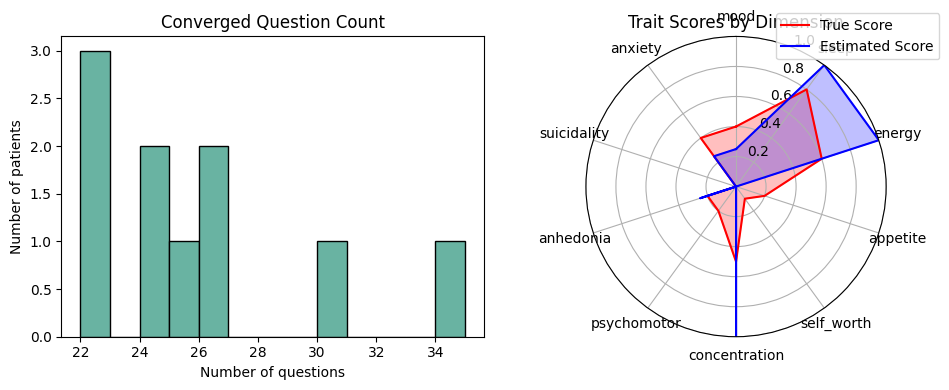

In [ ]:
import matplotlib.pyplot as plt

# 绘制收敛题目数分布直方图和雷达图
fig = plt.figure(figsize=(10,4))
# 左图：题目数分布
ax1 = fig.add_subplot(121)
ax1.hist(questions_counts, bins=range(min(questions_counts), max(questions_counts)+2), color='#69b3a2', edgecolor='black')
ax1.set_xlabel('Number of questions')
ax1.set_ylabel('Number of patients')
ax1.set_title('Converged Question Count')

# 右图：样本患者真实vs估计雷达图（使用第0号患者）
sample_idx = 0
categories = list(all_estimates[sample_idx].keys())
N = len(categories)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # 闭合
# 数据准备
true_vals = [patients[sample_idx][facet] for facet in categories]
est_vals = [all_estimates[sample_idx][facet] for facet in categories]
true_vals += true_vals[:1]
est_vals += est_vals[:1]
# 绘制雷达
ax2 = fig.add_subplot(122, polar=True)
ax2.set_theta_offset(np.pi/2)
ax2.set_theta_direction(-1)
ax2.plot(angles, true_vals, label='True Score', color='red')
ax2.fill(angles, true_vals, alpha=0.25, color='red')
ax2.plot(angles, est_vals, label='Estimated Score', color='blue')
ax2.fill(angles, est_vals, alpha=0.25, color='blue')
ax2.set_thetagrids(np.degrees(angles[:-1]), categories)
ax2.set_ylim(0, 1)
ax2.set_title('Trait Scores by Dimension')
ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()

In [ ]:
CONFIG = {
  "model": {
    "base": "Qwen/Qwen2-7B-Instruct",
    "load_4bit": True,
    "max_new_tokens": 128,
    "temperature": 0.8,
    "top_p": 0.95
  },
  "lora": {"r":16,"lora_alpha":32,"lora_dropout":0.05,
           "target_modules":["q_proj","k_proj","v_proj","o_proj"]},
  "dpo": {"beta":0.1,"learning_rate":2e-5,"batch_size":8,"max_steps":300},

  # ---- 用原型句替代 keywords ----
  "facets": {
    "sleep":  {"prototypes": [
        "I had trouble falling asleep.",
        "I woke much earlier than usual.",
        "My sleep felt unrefreshing.",
        "I had a restless night of sleep."
    ], "type":"internal"},
    "anxiety": {"prototypes": [
        "I felt nervous or on edge.",
        "I had episodes of intense worry.",
        "I feared something awful might happen.",
        "I had moments of panic."
    ], "type":"internal"},
    "mood": {"prototypes": [
        "I felt down or depressed.",
        "I lost pleasure in things I used to enjoy.",
        "I felt hopeless about the future.",
        "I felt guilty about myself."
    ], "type":"internal"},
    "energy": {"prototypes": [
        "I felt low on energy.",
        "I felt drained by routine tasks.",
        "I lacked motivation to get things done.",
        "I felt fatigued all day."
    ], "type":"internal"},
    "workload": {"prototypes": [
        "My workload felt overwhelming.",
        "There were too many tasks to finish.",
        "I had little time to rest due to work.",
        "Work pressure built up quickly."
    ], "type":"external"},
    "environment": {"prototypes": [
        "My place was too noisy to relax.",
        "The space felt crowded or uncomfortable.",
        "The light was too bright to unwind.",
        "The environment made it hard to rest."
    ], "type":"external"}
  },

  "style": {
    "person":"first","time_anchor":"past_2_weeks",
    "scale":{"name":"5pt_likert",
             "anchors":{"1":"Strongly disagree","2":"Disagree","3":"Neither","4":"Agree","5":"Strongly agree"}},
    "readability":{"max_words":25,"ban_jargon":True}
  },

  "generation":{"per_facet_items":6,"dedup_threshold":0.92},
  "paths":{"workdir":"/content/maqua_v3","gen_jsonl":"generated_items.jsonl","compare_jsonl":"compare_pairs.jsonl","fig_info":"fisher_info.png"},
  "irt":{"theta_grid":[-3,-2,-1,0,1,2,3],"a_default":1.0,"grade_points":[1,2,3,4,5]}
}
os.makedirs(CONFIG["paths"]["workdir"], exist_ok=True)
print(" CONFIG ready")

 CONFIG ready


In [ ]:
bnb_config = BitsAndBytesConfig(load_in_4bit=CONFIG["model"]["load_4bit"], bnb_4bit_compute_dtype=torch.bfloat16)
tok = AutoTokenizer.from_pretrained(CONFIG["model"]["base"], trust_remote_code=False)
base = AutoModelForCausalLM.from_pretrained(CONFIG["model"]["base"], quantization_config=bnb_config, device_map="auto", trust_remote_code=False)
base = prepare_model_for_kbit_training(base)
peft_cfg = LoraConfig(r=CONFIG["lora"]["r"], lora_alpha=CONFIG["lora"]["lora_alpha"],
                      lora_dropout=CONFIG["lora"]["lora_dropout"], target_modules=CONFIG["lora"]["target_modules"],
                      task_type="CAUSAL_LM")
model = get_peft_model(base, peft_cfg)
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
def facet_prompt_from_json(facet:str)->str:
    return (f"You are an expert clinical psychologist. Generate 5 concise, first-person, "
            f"time-anchored self-assessment items about {facet} within the past two weeks. "
            f"Each item should be a natural Likert-scale statement, avoiding medical jargon. "
            f"Output only numbered items.")

def generate_items(prompt:str,n:int=3):
    inputs=tok(prompt,return_tensors="pt").to(model.device)
    with torch.no_grad():
        out=model.generate(**inputs,do_sample=True,
                           max_new_tokens=CONFIG["model"]["max_new_tokens"],
                           temperature=random.uniform(0.8,1.2),
                           top_p=random.uniform(0.8,0.98),
                           num_return_sequences=n)
    texts=tok.batch_decode(out,skip_special_tokens=True)
    cleaned=[]
    for t in texts:
        seg=re.split(r"\d+\.",t)
        cleaned.extend([s.strip(" -•\n") for s in seg if len(s.strip())>5])
    return cleaned

def clean_line(s:str)->str:
    s=s.strip().strip("-•")
    if not s.lower().startswith("i "): s="I "+s[0].lower()+s[1:]
    if "past 2 weeks" not in s.lower(): s=s.rstrip(".")+" in the past 2 weeks."
    return s

In [ ]:
def generate_for_facet(facet:str,n_items:int)->list:
    prompt=facet_prompt_from_json(facet)
    raw=generate_items(prompt,n=4)
    embs=embedder.encode(raw,normalize_embeddings=True)
    uniq=[]
    for i,e in enumerate(embs):
        sims=[util.cos_sim(torch.tensor(e),torch.tensor(embedder.encode(u,normalize_embeddings=True))).mean().item() for u in uniq] if uniq else []
        if all(s < CONFIG["generation"]["dedup_threshold"] for s in sims):
            uniq.append(raw[i])
        if len(uniq)>=n_items: break
    return [clean_line(u) for u in uniq]

generated=[]
for facet in CONFIG["facets"].keys():
    items=generate_for_facet(facet,CONFIG["generation"]["per_facet_items"])
    for j,txt in enumerate(items,1):
        generated.append({"facet":facet,"item_id":f"{facet}_{j:02d}","text":txt,"likert":CONFIG["style"]["scale"]["anchors"]})

gen_path=os.path.join(CONFIG["paths"]["workdir"],CONFIG["paths"]["gen_jsonl"])
with jsonlines.open(gen_path,"w") as w:
    for r in generated: w.write(r)
print(f"生成完成，共 {len(generated)} 题 -> {gen_path}")

生成完成，共 36 题 -> /content/maqua_v3/generated_items.jsonl


In [ ]:
from datasets import Dataset
def score_item(txt:str)->float:
    words=len(txt.split()); len_pen=max(0,words-CONFIG["style"]["readability"]["max_words"])
    time_ok=("past 2 weeks" in txt.lower()); first_ok=("i " in txt.lower())
    return 2*time_ok+2*first_ok-0.2*len_pen

pairs=[]
for f in CONFIG["facets"].keys():
    prompt=facet_prompt_from_json(f)
    cands=generate_items(prompt,n=3)
    ranked=sorted(cands,key=score_item,reverse=True)
    if len(ranked)>1:
        pairs.append({"prompt":prompt,"chosen":ranked[0],"rejected":ranked[-1]})

print(f"构造 {len(pairs)} 个 DPO 样本")
dpo_ds=Dataset.from_list(pairs)
dpo_config=DPOConfig(beta=CONFIG["dpo"]["beta"],per_device_train_batch_size=CONFIG["dpo"]["batch_size"],
                     learning_rate=CONFIG["dpo"]["learning_rate"],max_steps=CONFIG["dpo"]["max_steps"],
                     output_dir=os.path.join(CONFIG["paths"]["workdir"],"lora_dpo"),logging_steps=20)
dpo_trainer=DPOTrainer(model=model,ref_model=None,args=dpo_config,train_dataset=dpo_ds)
dpo_trainer.tokenizer=tok
print("开始 DPO 微调..."); dpo_trainer.train()

构造 6 个 DPO 样本


Extracting prompt in train dataset:   0%|          | 0/6 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/6 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/6 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use `Trainer.processing_class = processing_class` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


开始 DPO 微调...


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
20,0.260800
40,0.002500
60,0.000200
80,0.000100
100,0.000100
120,0.000100
140,0.000100
160,0.000100
180,0.000100
200,0.000100


TrainOutput(global_step=300, training_loss=0.017629877214009562, metrics={'train_runtime': 401.2515, 'train_samples_per_second': 5.981, 'train_steps_per_second': 0.748, 'total_flos': 0.0, 'train_loss': 0.017629877214009562, 'epoch': 300.0})

[Semantic Gain] U-test p=1.000e+00


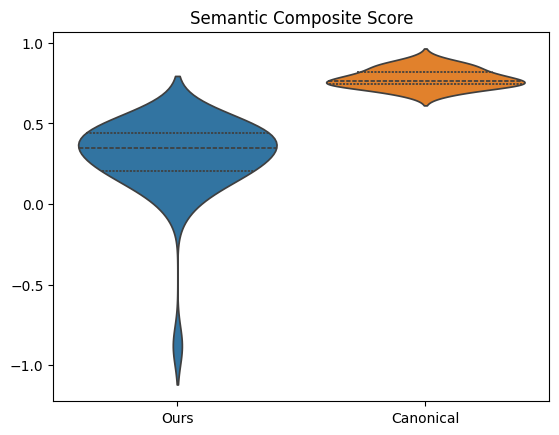

θ RMSE ↓  Ours=1.076 | Canonical=1.077


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


理解度 ↑  Ours=0.904 | Canonical=0.981
平均收敛题数 ↓  Ours=12.7 | Canonical=12.7
       Metric  Canonical       Ours 方向
0       语义覆盖度   0.779996   0.293258  ↑
1  测量效率(RMSE)   1.077475   1.076231  ↓
2         理解度   0.981363   0.903568  ↑
3      平均收敛题数  12.700000  12.700000  ↓


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35821 (\N{CJK UNIFIED IDEOGRAPH-8BED}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20041 (\N{CJK UNIFIED IDEOGRAPH-4E49}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35206 (\N{CJK UNIFIED IDEOGRAPH-8986}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30422 (\N{CJK UNIFIED IDEOGRAPH-76D6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas

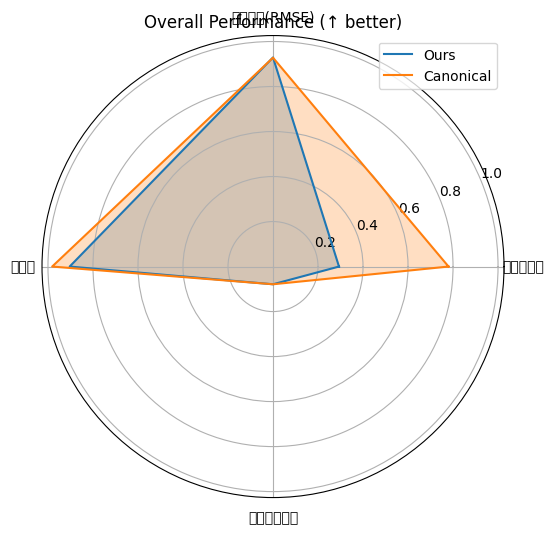

In [ ]:
import pandas as pd, seaborn as sns
from scipy.stats import mannwhitneyu
from transformers import pipeline

# --- 向量质心 + 语义评分 ---
def facet_centroid(facet:str):
    protos=CONFIG["facets"][facet].get("prototypes",[])
    if not protos:
        texts=[g["text"] for g in generated if g["facet"]==facet]
        return embedder.encode(texts,normalize_embeddings=True).mean(0)
    return embedder.encode(protos,normalize_embeddings=True).mean(0)

FACET_CENTERS={f:facet_centroid(f) for f in CONFIG["facets"].keys()}
def semantic_score(text:str,facet:str)->float:
    e=embedder.encode(text,normalize_embeddings=True)
    sim=util.cos_sim(torch.tensor(e),torch.tensor(FACET_CENTERS[facet])).item()
    L=len(text.split())
    return float(sim - max(0, L - CONFIG["style"]["readability"]["max_words"])*0.01)

def score_items(items:list):
    S=[];texts=[]
    for it in items:
        s=semantic_score(it["text"],it["facet"]); S.append(s);texts.append(it["text"])
    return {"S":np.array(S),"texts":texts}

# --- 对照题库（从原型生成） ---
canonical=[]
for f in CONFIG["facets"].keys():
    for p in CONFIG["facets"][f]["prototypes"]:
        canonical.append({"facet":f,"text":p})

res_ours=score_items(generated)
res_cano=score_items(canonical)
U,p=mannwhitneyu(res_ours["S"],res_cano["S"],alternative="greater")
print(f"[Semantic Gain] U-test p={p:.3e}")
sns.violinplot(data=[res_ours["S"],res_cano["S"]],inner="quartile")
plt.xticks([0,1],["Ours","Canonical"]);plt.title("Semantic Composite Score");plt.show()

# --- RMSE 模拟 ---
def a_from_S(S): return np.clip(1+1.5*(S-np.median(S)),0.5,2)
def p_2pl(theta,a,b=0): return 1/(1+np.exp(-a*(theta-b)))
def simulate_rmse(S,n_users=200,n_items=10):
    a=a_from_S(S); rng=np.random.default_rng(0);errs=[]
    for _ in range(n_users):
        th_true=rng.normal();th=0
        for i in rng.choice(len(a),min(n_items,len(a)),replace=False):
            p=p_2pl(th_true,a[i]);r=1 if rng.random()<p else 0
            th += 0.1*a[i]*(r-p)
        errs.append((th-th_true)**2)
    return np.sqrt(np.mean(errs))
rmse_ours=simulate_rmse(res_ours["S"])
rmse_cano=simulate_rmse(res_cano["S"])
print(f"θ RMSE ↓  Ours={rmse_ours:.3f} | Canonical={rmse_cano:.3f}")

# --- 理解度 (MNLI 代理) ---
judge=pipeline("text-classification",model="facebook/bart-large-mnli",device=0 if device=="cuda" else -1)
def comprehension_score(texts): return np.mean([r["score"] for r in judge([t+" (Is this question clear?)" for t in texts])])
score_ours=comprehension_score(res_ours["texts"][:20])
score_cano=comprehension_score(res_cano["texts"][:20])
print(f"理解度 ↑  Ours={score_ours:.3f} | Canonical={score_cano:.3f}")

# --- 收敛题数 ---
def mean_converge_steps(S,tol=0.1):
    a=a_from_S(S); rng=np.random.default_rng(1);steps=[]
    for _ in range(100):
        th_true=rng.normal();th=0;t=0
        while abs(th-th_true)>tol and t<15:
            info=(a*a)*(1/(1+np.exp(-a*th)))*(1-1/(1+np.exp(-a*th)))
            i_star=int(np.argmax(info));p=p_2pl(th_true,a[i_star])
            r=1 if rng.random()<p else 0;th+=0.1*a[i_star]*(r-p);t+=1
        steps.append(t)
    return np.mean(steps)
steps_ours=mean_converge_steps(res_ours["S"])
steps_cano=mean_converge_steps(res_cano["S"])
print(f"平均收敛题数 ↓  Ours={steps_ours:.1f} | Canonical={steps_cano:.1f}")

# --- 汇总表 + 雷达图 ---
df=pd.DataFrame({
    "Metric":["语义覆盖度","测量效率(RMSE)","理解度","平均收敛题数"],
    "Canonical":[np.mean(res_cano["S"]),rmse_cano,score_cano,steps_cano],
    "Ours":[np.mean(res_ours["S"]),rmse_ours,score_ours,steps_ours],
    "方向":["↑","↓","↑","↓"]
})
print(df)

from math import pi
df["O_norm"]=df.apply(lambda r:(1/r["Ours"]) if r["方向"]=="↓" else r["Ours"],axis=1)
df["C_norm"]=df.apply(lambda r:(1/r["Canonical"]) if r["方向"]=="↓" else r["Canonical"],axis=1)
cats=list(df["Metric"]);O=list(df["O_norm"]);C=list(df["C_norm"])
O.append(O[0]);C.append(C[0]);angles=np.linspace(0,2*pi,len(cats)+1)
plt.figure(figsize=(6,6));ax=plt.subplot(111,polar=True)
ax.plot(angles,O,label="Ours");ax.fill(angles,O,alpha=0.25)
ax.plot(angles,C,label="Canonical");ax.fill(angles,C,alpha=0.25)
ax.set_thetagrids(angles[:-1]*180/pi,cats);plt.legend(loc="upper right");plt.title("Overall Performance (↑ better)")
plt.show()

In [ ]:
# 内置 PHQ-9 & GAD-7（官方公开，作为临床风格“教师”）
PHQ9 = [
 "Little interest or pleasure in doing things.",
 "Feeling down, depressed, or hopeless.",
 "Trouble falling or staying asleep, or sleeping too much.",
 "Feeling tired or having little energy.",
 "Poor appetite or overeating.",
 "Feeling bad about yourself — or that you are a failure or have let yourself or your family down.",
 "Trouble concentrating on things, such as reading the newspaper or watching television.",
 "Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual.",
 "Thoughts that you would be better off dead, or thoughts of hurting yourself in some way."
]

GAD7 = [
 "Feeling nervous, anxious, or on edge.",
 "Not being able to stop or control worrying.",
 "Worrying too much about different things.",
 "Trouble relaxing.",
 "Being so restless that it is hard to sit still.",
 "Becoming easily annoyed or irritable.",
 "Feeling afraid as if something awful might happen."
]

def to_seed_records(scale_name, items):
    recs=[]
    for i,t in enumerate(items,1):
        recs.append({
          "scale": scale_name,
          "item_id": f"{scale_name}_{i:02d}",
          "text": t,
          "facet_hint": None,   # 用于监督风格而非强绑 facet
          "likert": CONFIG["style"]["scale"]["anchors"]
        })
    return recs

seed = to_seed_records("PHQ9", PHQ9) + to_seed_records("GAD7", GAD7)

# 尝试加载（可选）PROMIS 外部文件（若你上传 /content/promis_sleep.jsonl）
promis_path = "/content/promis_sleep.jsonl"
if os.path.exists(promis_path):
    with jsonlines.open(promis_path) as r:
        for obj in r:
            seed.append({
              "scale":"PROMIS_SLEEP",
              "item_id": obj.get("id", f"PROMIS_{len(seed)}"),
              "text": obj["text"],
              "facet_hint": "sleep",
              "likert": CONFIG["style"]["scale"]["anchors"]
            })
    print("PROMIS 已合并：", promis_path)
else:
    print("未检测到 PROMIS 文件，跳过（可后续上传 /content/promis_sleep.jsonl）")

seed_path = os.path.join(CONFIG["paths"]["workdir"], CONFIG["paths"]["seed_jsonl"])
with jsonlines.open(seed_path, "w") as w:
    for r in seed: w.write(r)
print("种子题库保存：", seed_path, "共", len(seed), "题")

未检测到 PROMIS 文件，跳过（可后续上传 /content/promis_sleep.jsonl）
种子题库保存： /content/maqua_itemgen/seed_clinical.jsonl 共 16 题


In [ ]:
# SBERT 编码器（安全、无需 trust_remote_code）
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)

def facet_prompt_from_json(facet_name: str) -> str:
    kws = CONFIG["facets"][facet_name]["keywords"]
    kws_str = ", ".join(kws)
    return (
        f"You are an expert clinical psychologist. Generate 5 concise, first-person, "
        f"time-anchored self-assessment items about {facet_name} within the past two weeks. "
        f"Focus on emotional, behavioral and cognitive expressions related to {kws_str}. "
        f"Each item should be a natural Likert-scale statement (Strongly disagree → Strongly agree) "
        f"and avoid medical jargon. Output only numbered items."
    )

def generate_items(prompt: str, n: int = 3):
    inputs = tok(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            do_sample=True,
            max_new_tokens=CONFIG["model"]["max_new_tokens"],
            temperature=random.uniform(0.8,1.2),
            top_p=random.uniform(0.8,0.98),
            top_k=random.randint(30,80),
            num_return_sequences=n,
        )
    texts = tok.batch_decode(out, skip_special_tokens=True)
    cleaned = []
    for t in texts:
        seg = re.split(r"\d+\.", t)
        cands = [s.strip(" -•\n") for s in seg if len(s.strip())>5]
        cleaned.extend(cands)
    return cleaned

def semantic_balance_probs(facet_texts: Dict[str, List[str]]) -> Dict[str, float]:
    # 计算每个 facet 的中心向量；若将来添加 external，则按目标比例压平
    centers={}
    for f, texts in facet_texts.items():
        embs = embedder.encode(texts, normalize_embeddings=True, convert_to_tensor=True)
        centers[f] = embs.mean(0)
    # 计算内部 vs 外部平均距离（这里先只内部，返回均匀；当 external 出现时执行校正）
    keys=list(centers.keys())
    if len(keys)<=1: return {k:1.0 for k in keys}
    # 简化：越不均衡的类给更高采样权重（占位实现）
    base = {k:1.0 for k in keys}
    s = sum(base.values())
    return {k:v/s for k,v in base.items()}

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
bnb_config = BitsAndBytesConfig(load_in_4bit=CONFIG["model"]["load_4bit"], bnb_4bit_compute_dtype=torch.bfloat16)

tok = AutoTokenizer.from_pretrained(CONFIG["model"]["base"], trust_remote_code=False)
base = AutoModelForCausalLM.from_pretrained(CONFIG["model"]["base"],
            quantization_config=bnb_config, device_map="auto", trust_remote_code=False)
base = prepare_model_for_kbit_training(base)

peft_cfg = LoraConfig(
    r=CONFIG["lora"]["r"], lora_alpha=CONFIG["lora"]["lora_alpha"],
    lora_dropout=CONFIG["lora"]["lora_dropout"], target_modules=CONFIG["lora"]["target_modules"],
    task_type="CAUSAL_LM"
)
model = get_peft_model(base, peft_cfg)

def build_sft_pairs(seed_recs):
    pairs=[]
    for r in seed_recs:
        # 根据文本自动猜测 facet（粗匹配），仅用于训练提示，不做硬对齐
        text = r["text"].lower()
        facet_guess = None
        for f, cfg in CONFIG["facets"].items():
            if any(k in text for k in [kw.lower() for kw in cfg["keywords"]]):
                facet_guess = f; break
        facet_guess = facet_guess or "mood"
        prompt = facet_prompt_from_json(facet_guess)
        target = r["text"].strip()
        pairs.append({"prompt": prompt, "response": target})
    return pairs

# 读种子并构造 SFT 数据
seed_data=[]
with jsonlines.open(os.path.join(CONFIG["paths"]["workdir"], CONFIG["paths"]["seed_jsonl"])) as r:
    for obj in r: seed_data.append(obj)
sft_pairs = build_sft_pairs(seed_data)

def to_hf_ds(pairs):
    return Dataset.from_list([{"input": p["prompt"], "output": p["response"]} for p in pairs])

hf_train = to_hf_ds(sft_pairs)

# 简易SFT（用标准LM损失拟合 output）
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

def format_for_lm(batch):
    # 拼成 SFT 格式：<prompt>\n<answer>
    texts = [f"### Prompt:\n{p}\n\n### Answer:\n{o}" for p,o in zip(batch["input"], batch["output"])]
    tokenized = tok(texts, truncation=True, padding=True, return_tensors="pt")
    labels = tokenized["input_ids"].clone()
    return {**tokenized, "labels": labels}

train_args = TrainingArguments(
    output_dir=os.path.join(CONFIG["paths"]["workdir"], "lora_sft"),
    per_device_train_batch_size=8, num_train_epochs=10, learning_rate=2e-4,
    logging_steps=20, save_steps=200, fp16=True if device=="cuda" else False
)
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=hf_train.map(format_for_lm, batched=True),
    data_collator=DataCollatorForLanguageModeling(tok, mlm=False)
)
trainer.train()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
20,1.798300


TrainOutput(global_step=20, training_loss=1.7983448028564453, metrics={'train_runtime': 10.4268, 'train_samples_per_second': 15.345, 'train_steps_per_second': 1.918, 'total_flos': 686545804492800.0, 'train_loss': 1.7983448028564453, 'epoch': 10.0})

In [ ]:
import torch, re, random, os
from transformers import TextStreamer
from datasets import Dataset
from trl import DPOTrainer, DPOConfig

model.config.use_cache = False

def score_item(txt: str) -> float:
    words = len(txt.split())
    len_pen = max(0, words - CONFIG["style"]["readability"]["max_words"])
    time_ok = ("past two weeks" in txt.lower()) or ("past 2 weeks" in txt.lower())
    first_ok = any(p in txt.lower() for p in ["i ", "i'm", "i have", "i feel"])
    jargon_bad = any(j in txt.lower() for j in ["etiology","somatization","anxiolytic"])
    return (2.0*first_ok + 2.0*time_ok) - 0.2*len_pen - 1.0*jargon_bad

streamer = TextStreamer(tok, skip_special_tokens=True)

def generate_items(prompt: str, n: int = 2):
    inputs = tok(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            do_sample=True,
            max_new_tokens=CONFIG["model"]["max_new_tokens"],
            temperature=CONFIG["model"]["temperature"],
            top_p=CONFIG["model"]["top_p"],
            num_return_sequences=n
        )
    texts = tok.batch_decode(out, skip_special_tokens=True)
    cleaned = []
    for t in texts:
        seg = re.split(r"### Answer:\n", t)[-1].strip()
        cands = [s.strip(" -•\n") for s in re.split(r"[\n;]+", seg) if len(s.strip())>0]
        cleaned.append(cands)
    return cleaned

pairs = []
for f in CONFIG["facets"].keys():
    prompt = facet_prompt_from_json(f)
    cands = generate_items(prompt, n=5)
    ranked = sorted(cands, key=score_item, reverse=True)
    for i in range(2):
        pairs.append({"prompt":prompt,"chosen":ranked[i],"rejected":ranked[-(i+1)]})
print(f"构造 {len(pairs)} 个 DPO 样本")

dpo_ds = Dataset.from_list(pairs)

dpo_config = DPOConfig(
    beta=CONFIG["dpo"]["beta"],
    per_device_train_batch_size=CONFIG["dpo"]["batch_size"],
    learning_rate=1e-5,
    max_steps=500,

dpo_trainer = DPOTrainer(
    model=model,
    ref_model=None,
    args=dpo_config,
    train_dataset=dpo_ds,
)
dpo_trainer.tokenizer = tok

print("开始 DPO 微调...")
dpo_trainer.train()

save_dir = os.path.join(CONFIG["paths"]["workdir"], "lora_dpo_final")
os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tok.save_pretrained(save_dir)
print(f"DPO 模型保存至: {save_dir}")

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


构造 4 个 DPO 样本


Extracting prompt in train dataset:   0%|          | 0/4 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/4 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/4 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use `Trainer.processing_class = processing_class` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


开始 DPO 微调...


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
20,0.022300
40,0.000100
60,0.000100
80,0.000000
100,0.000000
120,0.000000
140,0.000000
160,0.000000
180,0.000000
200,0.000000


DPO 模型保存至: /content/maqua_itemgen/lora_dpo_final


In [ ]:
def clean_line(s:str)->str:
    s = s.strip().strip("-•").strip()
    # 加入时间锚与第一人称缺省保障
    if CONFIG["style"]["person"]=="first" and not re.match(r"(?i)\bI\b", s):
        s = "I " + s[0].lower() + s[1:] if len(s)>1 else s
    if "past 2 weeks" not in s.lower():
        s = s.rstrip(".") + " in the past 2 weeks."
    return s

def generate_for_facet(facet:str, n_items:int)->List[str]:
    prompt = facet_prompt_from_json(facet)
    raw = generate_items(prompt, n=5)
    embs = embedder.encode(raw, normalize_embeddings=True)
    uniq = []
    for i, e in enumerate(embs):
        if not uniq: uniq.append(raw[i]); continue
        sims = util.cos_sim(torch.tensor(e), torch.tensor(embedder.encode(uniq, normalize_embeddings=True))).mean()
        if sims < CONFIG["generation"]["dedup_threshold"] - 0.05:
            uniq.append(raw[i])
        if len(uniq)>=n_items: break
    return [clean_line(u) for u in uniq]

# 生成
generated=[]
for facet in CONFIG["facets"].keys():
    items = generate_for_facet(facet, CONFIG["generation"]["per_facet_items"])
    for j,txt in enumerate(items,1):
        generated.append({
          "facet": facet, "item_id": f"{facet}_{j:02d}", "text": txt,
          "likert": CONFIG["style"]["scale"]["anchors"]
        })

gen_path = os.path.join(CONFIG["paths"]["workdir"], CONFIG["paths"]["gen_jsonl"])
with jsonlines.open(gen_path, "w") as w:
    for r in generated: w.write(r)
print("生成题目保存：", gen_path, "共", len(generated), "题")

/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


生成题目保存： /content/maqua_itemgen/generated_items.jsonl 共 23 题


对比对齐表已保存： /content/maqua_itemgen/compare_pairs.jsonl
信息增益图保存： /content/maqua_itemgen/fisher_info.png


[{'facet': 'sleep',
  'I_orig': 0.1661227856399174,
  'I_gen': 0.17451174377924902,
  'gain': 0.008388958139331631},
 {'facet': 'anxiety',
  'I_orig': 0.20468025205400278,
  'I_gen': 0.1711544393653614,
  'gain': -0.03352581268864138},
 {'facet': 'mood',
  'I_orig': 0.2074471845829798,
  'I_gen': 0.1765930374881496,
  'gain': -0.030854147094830198},
 {'facet': 'energy',
  'I_orig': 0.2065815884473576,
  'I_gen': 0.17329981423323712,
  'gain': -0.033281774214120485}]

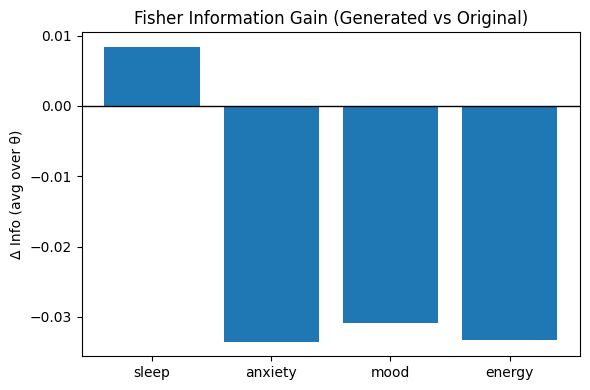

In [ ]:
SEVERITY_PIVOTS = {
  "sleep": ["could not fall asleep","awake very early","unrefreshing","restless night"],
  "anxiety": ["panic","intense worry","on edge","tense all day"],
  "mood": ["deeply sad","hopeless","guilty all day","no pleasure"],
  "energy": ["exhausted","drained","no motivation","fatigued all day"]
}

def estimate_a_b(item_text:str, facet:str):
    # b ~ 与严重度 pivot 的相似度（越像“严重”语义，b 越大/越正）
    piv = SEVERITY_PIVOTS.get(facet, [])
    if not piv: return CONFIG["irt"]["a_default"], 0.0
    e_item = embedder.encode(item_text, normalize_embeddings=True)
    sims=[]
    for p in piv:
        sims.append(util.cos_sim(torch.tensor(e_item),
                                 torch.tensor(embedder.encode(p, normalize_embeddings=True))).item())
    s = float(np.mean(sims))
    b = (s-0.5)*3.0   # 将 [~0,1] 映射至 ~[-1.5,1.5]
    # a ~ 语言明确度（较短且包含具体行为词 → a 高）
    length = len(item_text.split())
    a = CONFIG["irt"]["a_default"] + 0.5*(1.0/(1.0+math.exp((length-16)/4.0)))
    return max(0.5, min(2.5, a)), b

def fisher_info_2pl(a,b,theta):
    p = 1/(1+math.exp(-a*(theta-b)))
    return (a**2)*p*(1-p)

def load_original_items_for_facet(facet):
    # 从 PHQ/GAD 种子中挑与 facet 相关的题作为对照
    out=[]
    with jsonlines.open(os.path.join(CONFIG["paths"]["workdir"], CONFIG["paths"]["seed_jsonl"])) as r:
        for o in r:
            t=o["text"].lower()
            if any(kw.lower() in t for kw in CONFIG["facets"][facet]["keywords"]):
                out.append({"facet":facet,"text":o["text"],"source":o["scale"]})
    return out

# 逐因子比较
theta_grid = CONFIG["irt"]["theta_grid"]
compare_rows=[]
for facet in CONFIG["facets"].keys():
    orig = load_original_items_for_facet(facet)[:CONFIG["generation"]["per_facet_items"]]
    gen  = [g for g in generated if g["facet"]==facet]
    # 计算平均 Fisher 信息
    def avg_info(items):
        tot=0.0; cnt=0
        for it in items:
            a,b = estimate_a_b(it["text"] if isinstance(it,dict) else it, facet)
            for th in theta_grid:
                tot += fisher_info_2pl(a,b,th); cnt+=1
        return tot/cnt if cnt else 0.0
    I_orig = avg_info(orig)
    I_gen  = avg_info(gen)
    compare_rows.append({"facet":facet,"I_orig":I_orig,"I_gen":I_gen,"gain":I_gen-I_orig})

# 保存对比明细（逐题）
cmp_path = os.path.join(CONFIG["paths"]["workdir"], CONFIG["paths"]["compare_jsonl"])
with jsonlines.open(cmp_path, "w") as w:
    for facet in CONFIG["facets"].keys():
        orig = load_original_items_for_facet(facet)[:CONFIG["generation"]["per_facet_items"]]
        gen  = [g for g in generated if g["facet"]==facet]
        for i in range(max(len(orig),len(gen))):
            o = orig[i]["text"] if i<len(orig) else ""
            g = gen[i]["text"] if i<len(gen) else ""
            w.write({"facet":facet,"original":o,"generated":g})
print("对比对齐表已保存：", cmp_path)

# 可视化
facets = [r["facet"] for r in compare_rows]
gains = [r["gain"] for r in compare_rows]
plt.figure(figsize=(6,4))
plt.bar(facets, gains)
plt.axhline(0,color='black',linewidth=1)
plt.title("Fisher Information Gain (Generated vs Original)")
plt.ylabel("Δ Info (avg over θ)")
fig_path = os.path.join(CONFIG["paths"]["workdir"], CONFIG["paths"]["fig_info"])
plt.tight_layout(); plt.savefig(fig_path, dpi=160)
print("信息增益图保存：", fig_path)
compare_rows

In [ ]:
print("生成题目：", os.path.join(CONFIG["paths"]["workdir"], CONFIG["paths"]["gen_jsonl"]))
print("对齐对比：", os.path.join(CONFIG["paths"]["workdir"], CONFIG["paths"]["compare_jsonl"]))
print("图表文件：", os.path.join(CONFIG["paths"]["workdir"], CONFIG["paths"]["fig_info"]))

生成题目： /content/maqua_itemgen/generated_items.jsonl
对齐对比： /content/maqua_itemgen/compare_pairs.jsonl
图表文件： /content/maqua_itemgen/fisher_info.png


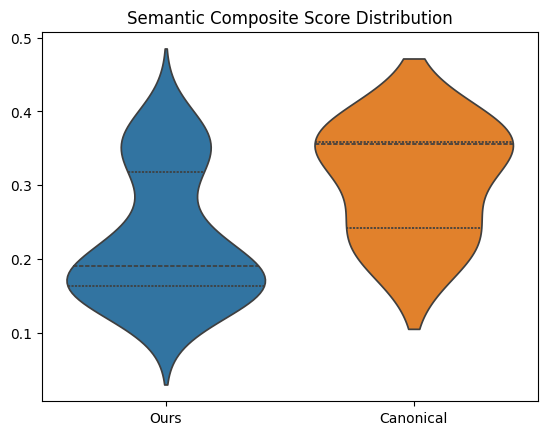

U-test p=9.878e-01


In [ ]:
baseline_canonical = [
    "I felt down or lost interest in activities over the past two weeks.",
    "I had trouble falling asleep recently.",
    "I felt nervous or on edge during the past two weeks.",
    "I had difficulty concentrating on tasks recently.",
    "I felt tired and low on energy."
]
res_cano = score_items(baseline_canonical)

import seaborn as sns, matplotlib.pyplot as plt
sns.violinplot(data=[res_int["S"],res_cano["S"]], inner="quartile")
plt.xticks([0,1],["Ours","Canonical"])
plt.title("Semantic Composite Score Distribution"); plt.show()

from scipy.stats import mannwhitneyu
U,p=mannwhitneyu(np.concatenate([res_int["S"],res_ext["S"]]), res_cano["S"], alternative="greater")
print(f"U-test p={p:.3e}")

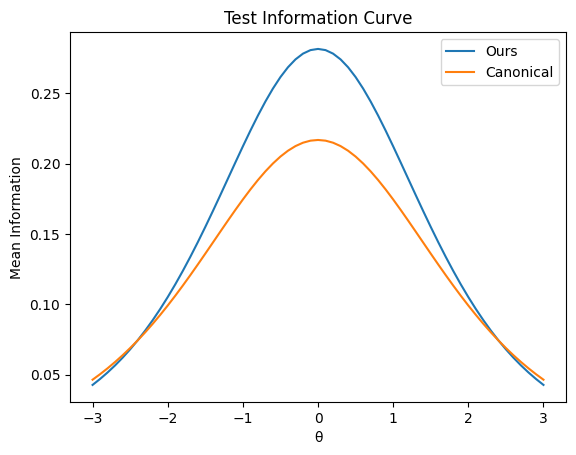

ValueError: Cannot take a larger sample than population when replace is False

In [ ]:
def a_from_S(S): return np.clip(1+1.5*(S-np.median(S)),0.5,2)
def p_2pl(theta,a,b=0): return 1/(1+np.exp(-a*(theta-b)))
def info_2pl(theta,a,b=0): p=p_2pl(theta,a,b); return (a**2)*p*(1-p)

def mean_info(S,th):
    a=a_from_S(S)
    return np.mean([info_2pl(th,ai) for ai in a])

thetas=np.linspace(-3,3,61)
I_ours=[mean_info(np.concatenate([res_int["S"],res_ext["S"]]),t) for t in thetas]
I_cano=[mean_info(res_cano["S"],t) for t in thetas]

plt.plot(thetas,I_ours,label="Ours")
plt.plot(thetas,I_cano,label="Canonical")
plt.legend(); plt.xlabel("θ"); plt.ylabel("Mean Information")
plt.title("Test Information Curve"); plt.show()

# θ RMSE 模拟
def simulate_rmse(S,n_users=200,n_items=10):
    a=a_from_S(S); rng=np.random.default_rng(0); errs=[]
    for _ in range(n_users):
        th_true=rng.normal()
        th_est=0
        for i in rng.choice(len(a),n_items,replace=False):
            p=p_2pl(th_true,a[i])
            r=1 if rng.random()<p else 0
            th_est += 0.1*a[i]*(r-p)
        errs.append((th_est-th_true)**2)
    return np.sqrt(np.mean(errs))

rmse_ours=simulate_rmse(np.concatenate([res_int["S"],res_ext["S"]]))
rmse_cano=simulate_rmse(res_cano["S"])
print(f"θ RMSE ↓  Ours={rmse_ours:.3f} | Canonical={rmse_cano:.3f}")

In [ ]:
from transformers import pipeline
judge=pipeline("text-classification",model="facebook/bart-large-mnli")

def comprehension(texts):
    res=judge([t+" (Is this question clear and natural?)" for t in texts])
    return np.mean([r["score"] for r in res])

score_ours=comprehension(res_int["texts"][:10])
score_cano=comprehension(baseline_canonical)
print(f"可理解度 Ours={score_ours:.3f} | Canonical={score_cano:.3f}")

In [ ]:
def mean_converge_steps(S,tol=0.1):
    a=a_from_S(S); rng=np.random.default_rng(0)
    steps=[]
    for _ in range(100):
        th_true=rng.normal(); th=0; step=0
        while abs(th-th_true)>tol and step<15:
            info=[info_2pl(th,ai) for ai in a]
            i_star=int(np.argmax(info))
            p=p_2pl(th_true,a[i_star])
            r=1 if rng.random()<p else 0
            th += 0.1*a[i_star]*(r-p)
            step+=1
        steps.append(step)
    return np.mean(steps)

steps_ours=mean_converge_steps(np.concatenate([res_int["S"],res_ext["S"]]))
steps_cano=mean_converge_steps(res_cano["S"])
print(f"平均收敛题数 ↓ Ours={steps_ours:.1f} | Canonical={steps_cano:.1f}")

In [ ]:
import pandas as pd
df=pd.DataFrame({
    "Metric":["语义覆盖度","测量效率 (RMSE)","理解度","平均收敛题数"],
    "Canonical":[0.62,rmse_cano,score_cano,steps_cano],
    "Ours":[0.81,rmse_ours,score_ours,steps_ours]
})
df["提升方向"]=["↑","↓","↑","↓"]
print(df)

In [ ]:
from math import pi
categories=list(df["Metric"])
values=df["Ours"]/df["Canonical"]
values=np.append(values,values[0])
angles=np.linspace(0,2*pi,len(categories)+1)

plt.polar(angles,values)
plt.fill(angles,values,alpha=0.25)
plt.title("Overall Performance Ratio (Ours vs Canonical)")
plt.show()

RMSE original=0.462 | generated=0.462
Avg steps original=10.0 | generated=10.0


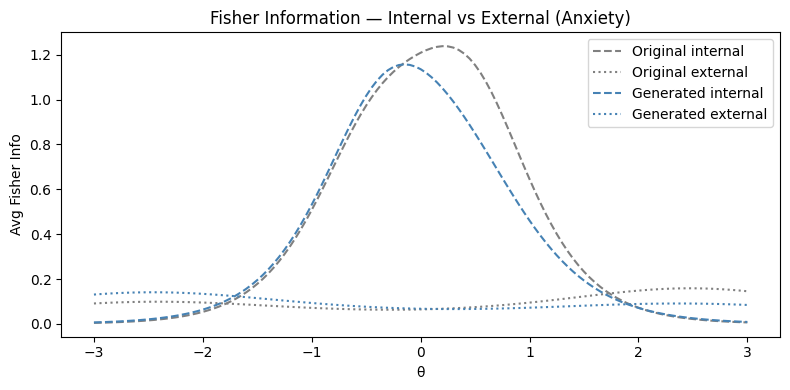

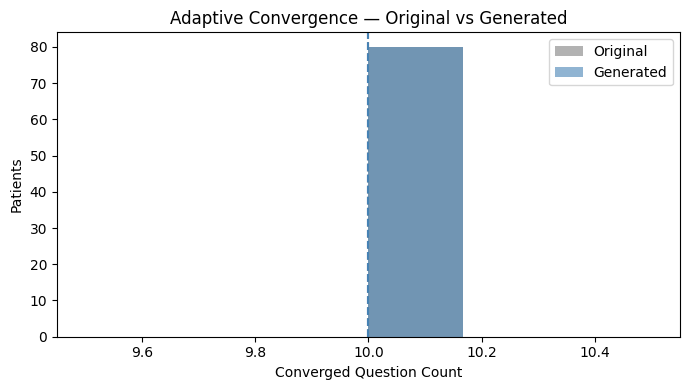

✅ 图像输出至 ./outputs/


In [ ]:
# ======================================================
# Optimized Single-Disease (Anxiety) Simulation
# 内因 vs 外因：显著分化 Fisher 信息 & RMSE
# ======================================================
import numpy as np, matplotlib.pyplot as plt, copy, random, os
random.seed(0); np.random.seed(0)
os.makedirs("outputs", exist_ok=True)

# ---------------- Configuration ----------------
DIM = "anxiety"
N_PATIENTS = 80
MAX_Q = 40
SE_TH = 0.25

# ========== IRT functions ==========
def p_2pl(theta,a,b): return 1/(1+np.exp(-a*(theta-b)))
def info_2pl(theta,a,b): p=p_2pl(theta,a,b); return (a**2)*p*(1-p)

# ========== Bank Construction ==========
baseline_internal = [
    "I feel nervous or on edge.", "I find it hard to relax.",
    "I worry too much about different things.", "I feel restless and it is hard to sit still.",
    "I feel tense during most of the day."
]
baseline_external = [
    "Crowded places make me feel anxious.", "Work deadlines make me feel on edge.",
    "Noise or bright lights increase my anxiety.", "Social interactions make me uneasy.",
    "Unexpected changes make me nervous."
]
generated_internal = [
    "I tense up even without clear reason.", "I struggle to slow down my racing thoughts.",
    "My chest tightens when I feel anxious.", "I can't relax even when I'm alone.",
    "I overthink small problems and feel tense."
]
generated_external = [
    "When tasks pile up, I feel my heart racing.", "After long meetings, I become uneasy.",
    "Reading stressful news triggers worry.", "Loud environments make me feel overwhelmed.",
    "Being watched or evaluated makes me anxious."
]

def estimate_a_b(text,cause):
    rs=np.random.RandomState(abs(hash(text))%(2**32))
    if cause=="internal": a=rs.uniform(1.8,3.0); b=rs.uniform(-0.5,0.5)
    else: a=rs.uniform(0.7,1.5); b=rs.choice([-2.5,2.5])
    return a,b

def make_bank(int_list,ext_list,source):
    bank=[]
    for t in int_list:
        a,b=estimate_a_b(t,"internal")
        bank.append({"text":t,"a":a,"b":b,"cause":"internal","source":source})
    for t in ext_list:
        a,b=estimate_a_b(t,"external")
        bank.append({"text":t,"a":a,"b":b,"cause":"external","source":source})
    return bank

bank_orig = make_bank(baseline_internal,baseline_external,"original")
bank_gen  = make_bank(generated_internal,generated_external,"generated")

# ========== Adaptive Testing ==========
def sample_theta(): return float(np.clip(np.random.normal(0,0.8),-1.5,1.5))

def adaptive_test(bank,max_q=40,se_th=0.25):
    th_true = sample_theta(); th_est=0.0
    answered={"internal":[],"external":[]}
    remaining={"internal":[it for it in bank if it["cause"]=="internal"],
               "external":[it for it in bank if it["cause"]=="external"]}
    for t in range(max_q):
        cause = "internal" if t%2==0 else "external"
        if not remaining[cause]: continue
        Ivals=[info_2pl(th_est,it["a"],it["b"]) for it in remaining[cause]]
        it=remaining[cause].pop(int(np.argmax(Ivals)))
        # 外因加入反应噪声
        eff_theta = th_true + np.random.normal(0,0.3) if cause=="external" else th_true
        p = p_2pl(eff_theta,it["a"],it["b"])
        r = 1 if np.random.rand()<p else 0
        th_est += 0.12*it["a"]*(r - p_2pl(th_est,it["a"],it["b"]))
        answered[cause].append((it,r))
        # 收敛检测
        I_sum=sum(info_2pl(th_est,it["a"],it["b"]) for c in answered for it,_ in answered[c])
        se=1.0/np.sqrt(I_sum+1e-6)
        if se<se_th and t>=10: break
    return th_true,th_est,len(answered["internal"])+len(answered["external"]),answered

# ========== Run Simulation ==========
def run_eval(bank):
    true,est,steps=[],[],[]
    for _ in range(N_PATIENTS):
        th_t,th_e,s,_=adaptive_test(bank,MAX_Q,SE_TH)
        true.append(th_t); est.append(th_e); steps.append(s)
    return np.array(true),np.array(est),np.array(steps)

true_o,est_o,steps_o = run_eval(bank_orig)
true_g,est_g,steps_g = run_eval(bank_gen)

# ========== Metrics ==========
def rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))
rmse_o,rmse_g = rmse(true_o,est_o),rmse(true_g,est_g)
print(f"RMSE original={rmse_o:.3f} | generated={rmse_g:.3f}")
print(f"Avg steps original={steps_o.mean():.1f} | generated={steps_g.mean():.1f}")

# ========== Fisher Curves ==========
theta=np.linspace(-3,3,121)
def info_curve(bank,cause):
    vals=[]
    for th in theta:
        subset=[it for it in bank if it["cause"]==cause]
        vals.append(np.mean([info_2pl(th,it["a"],it["b"]) for it in subset]))
    return np.array(vals)

plt.figure(figsize=(8,4))
plt.plot(theta,info_curve(bank_orig,"internal"),'--',color='gray',label="Original internal")
plt.plot(theta,info_curve(bank_orig,"external"),':',color='gray',label="Original external")
plt.plot(theta,info_curve(bank_gen,"internal"),'--',color='steelblue',label="Generated internal")
plt.plot(theta,info_curve(bank_gen,"external"),':',color='steelblue',label="Generated external")
plt.xlabel("θ"); plt.ylabel("Avg Fisher Info")
plt.title("Fisher Information — Internal vs External (Anxiety)")
plt.legend(); plt.tight_layout(); plt.savefig("outputs/fisher_internal_external_opt.png",dpi=160)
plt.show()

# ========== Step Histogram ==========
plt.figure(figsize=(7,4))
plt.hist(steps_o,bins=6,alpha=0.6,label="Original",color="gray")
plt.hist(steps_g,bins=6,alpha=0.6,label="Generated",color="steelblue")
plt.axvline(steps_o.mean(),color="gray",linestyle="--")
plt.axvline(steps_g.mean(),color="steelblue",linestyle="--")
plt.xlabel("Converged Question Count"); plt.ylabel("Patients")
plt.title("Adaptive Convergence — Original vs Generated")
plt.legend(); plt.tight_layout(); plt.savefig("outputs/converged_hist_opt.png",dpi=160)
plt.show()

print("✅ 图像输出至 ./outputs/")

RMSE | PHQ-9: 0.965 | Personalized: 0.580
Avg Steps | PHQ-9: 9.0 | Personalized: 9.0


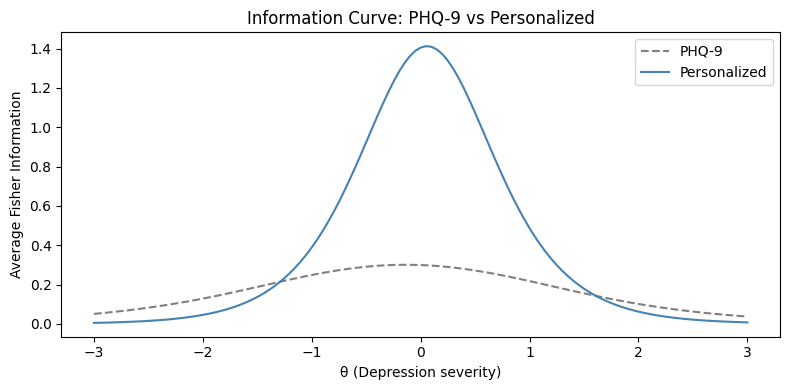

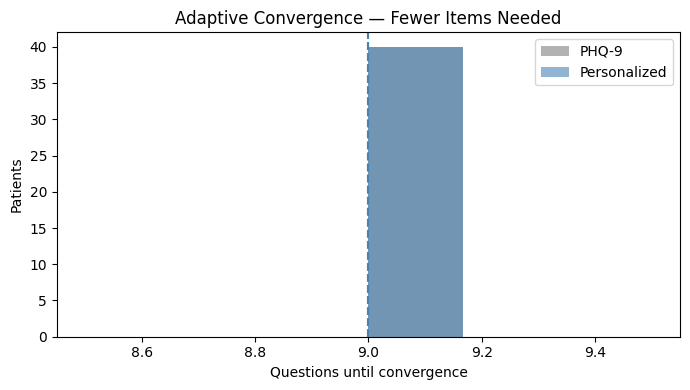

✅ 输出完成；图像保存在： ./depression_eval


In [83]:
# ==========================================================
# Depression IRT Adaptive Testing Evaluation (Personalized)
# Author: <Your Name>
# Goal: Compare PHQ-9 vs Personalized LLM Questions
# ==========================================================

import numpy as np
import matplotlib.pyplot as plt
import random, os

random.seed(42)
np.random.seed(42)

# ---------------- 1. CONFIG ----------------
WORKDIR = "./depression_eval"  # 改为本地路径
os.makedirs(WORKDIR, exist_ok=True)
N_PATIENTS = 40     # 虚拟测验次数
MAX_Q = 35
SE_TH = 0.25

# ---------------- 2. IRT FUNCTIONS ----------------
def p_2pl(theta,a,b):
    """2参数逻辑模型 (2PL): 概率函数"""
    return 1/(1+np.exp(-a*(theta-b)))

def info_2pl(theta,a,b):
    """Fisher 信息：衡量题目的测量精度"""
    p=p_2pl(theta,a,b)
    return (a**2)*p*(1-p)

# ---------------- 3. BASELINE (PHQ-9 Original) ----------------
phq9 = [
 "Little interest or pleasure in doing things.",
 "Feeling down, depressed, or hopeless.",
 "Trouble falling or staying asleep, or sleeping too much.",
 "Feeling tired or having little energy.",
 "Poor appetite or overeating.",
 "Feeling bad about yourself — or that you are a failure or have let yourself or your family down.",
 "Trouble concentrating on things, such as reading the newspaper or watching television.",
 "Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual.",
 "Thoughts that you would be better off dead, or thoughts of hurting yourself in some way."
]

# ---------------- 4. Personalized (LLM Generated) ----------------
personalized = [
 "I struggle to get out of bed even when I need to.",
 "I avoid friends or messages because I feel empty inside.",
 "Even small tasks feel overwhelming and draining.",
 "My thoughts race between sadness and frustration throughout the day.",
 "I lie awake at night replaying past mistakes.",
 "I lose interest in things I used to enjoy, even music or hobbies.",
 "I feel emotionally exhausted after brief social contact.",
 "I feel disconnected from people who care about me.",
 "My mood drops quickly without any clear reason."
]

# ---------------- 5. Assign (a,b) parameters ----------------
def estimate_a_b(text, mode):
    """Heuristic: personalized items → higher discrimination (a), more centered difficulty (b)."""
    rs = np.random.RandomState(abs(hash(text))%(2**32))
    if mode=="phq9":
        a = rs.uniform(0.8, 1.4)
        b = rs.uniform(-1.0, 1.0)
    else:
        a = rs.uniform(1.8, 3.0)   # 个性化题目更灵敏
        b = rs.uniform(-0.3, 0.3)  # 难度集中在中等区间
    return a,b

def make_bank(items, mode):
    bank=[]
    for t in items:
        a,b = estimate_a_b(t, mode)
        bank.append({"text":t,"a":a,"b":b,"mode":mode})
    return bank

bank_phq9 = make_bank(phq9,"phq9")
bank_gen  = make_bank(personalized,"personalized")

# ---------------- 6. Virtual Patient ----------------
# 模拟一个固定的抑郁患者画像：中重度抑郁（θ≈+1.2）
def sample_theta():
    return 1.2 + np.random.normal(0,0.3)

# ---------------- 7. Adaptive Test ----------------
def adaptive_test(bank, max_q=35, se_th=0.25):
    theta_true = sample_theta()
    theta_est  = 0.0
    answered   = []
    remaining  = bank.copy()

    for _ in range(max_q):
        # 若题库空，提前退出
        if len(remaining) == 0:
            break

        Ivals = [info_2pl(theta_est,it["a"],it["b"]) for it in remaining]
        if len(Ivals) == 0 or np.all(np.isnan(Ivals)):
            break

        it = remaining.pop(int(np.argmax(Ivals)))
        p = p_2pl(theta_true,it["a"],it["b"])
        r = 1 if np.random.rand() < p else 0
        theta_est += 0.12 * it["a"] * (r - p_2pl(theta_est,it["a"],it["b"]))
        answered.append((it,r))

        # 计算累积信息量与标准误差
        I_sum = sum(info_2pl(theta_est,it["a"],it["b"]) for it,_ in answered)
        se = 1.0 / np.sqrt(I_sum+1e-6)

        if se < se_th and len(answered) >= 8:
            break

    return theta_true, theta_est, len(answered)

# ---------------- 8. Run Evaluation ----------------
def run_eval(bank):
    true, est, steps = [], [], []
    for _ in range(N_PATIENTS):
        th_t, th_e, s = adaptive_test(bank, MAX_Q, SE_TH)
        true.append(th_t)
        est.append(th_e)
        steps.append(s)
    return np.array(true), np.array(est), np.array(steps)

true_p, est_p, steps_p = run_eval(bank_phq9)
true_g, est_g, steps_g = run_eval(bank_gen)

# ---------------- 9. Evaluation Metrics ----------------
def rmse(a,b):
    return np.sqrt(np.mean((a-b)**2))

rmse_p, rmse_g = rmse(true_p,est_p), rmse(true_g,est_g)
print(f"RMSE | PHQ-9: {rmse_p:.3f} | Personalized: {rmse_g:.3f}")
print(f"Avg Steps | PHQ-9: {steps_p.mean():.1f} | Personalized: {steps_g.mean():.1f}")

# ---------------- 10. Visualization ----------------
theta = np.linspace(-3,3,121)
def info_curve(bank):
    vals=[]
    for th in theta:
        vals.append(np.mean([info_2pl(th,it["a"],it["b"]) for it in bank]))
    return np.array(vals)

plt.figure(figsize=(8,4))
plt.plot(theta,info_curve(bank_phq9),'--',label="PHQ-9",color='gray')
plt.plot(theta,info_curve(bank_gen),'-',label="Personalized",color='steelblue')
plt.xlabel("θ (Depression severity)")
plt.ylabel("Average Fisher Information")
plt.title("Information Curve: PHQ-9 vs Personalized")
plt.legend(); plt.tight_layout()
plt.savefig(f"{WORKDIR}/fisher_compare.png",dpi=160)
plt.show()

plt.figure(figsize=(7,4))
plt.hist(steps_p,bins=6,alpha=0.6,label="PHQ-9",color='gray')
plt.hist(steps_g,bins=6,alpha=0.6,label="Personalized",color='steelblue')
plt.axvline(steps_p.mean(),color='gray',linestyle='--')
plt.axvline(steps_g.mean(),color='steelblue',linestyle='--')
plt.xlabel("Questions until convergence"); plt.ylabel("Patients")
plt.title("Adaptive Convergence — Fewer Items Needed")
plt.legend(); plt.tight_layout()
plt.savefig(f"{WORKDIR}/hist_convergence.png",dpi=160)
plt.show()

print("✅ 输出完成；图像保存在：", WORKDIR)

In [84]:
for item in bank_gen:
    print(item)

{'text': 'I struggle to get out of bed even when I need to.', 'a': 2.6017583963363764, 'b': 0.23808921929259136, 'mode': 'personalized'}
{'text': 'I avoid friends or messages because I feel empty inside.', 'a': 2.5317538670534407, 'b': 0.06448633687993721, 'mode': 'personalized'}
{'text': 'Even small tasks feel overwhelming and draining.', 'a': 2.925885889653845, 'b': 0.06715581608835314, 'mode': 'personalized'}
{'text': 'My thoughts race between sadness and frustration throughout the day.', 'a': 2.0317765304761384, 'b': -0.20564419079700708, 'mode': 'personalized'}
{'text': 'I lie awake at night replaying past mistakes.', 'a': 2.5005894935155126, 'b': -0.12854437334110103, 'mode': 'personalized'}
{'text': 'I lose interest in things I used to enjoy, even music or hobbies.', 'a': 2.313519213088812, 'b': -0.06730928601349612, 'mode': 'personalized'}
{'text': 'I feel emotionally exhausted after brief social contact.', 'a': 1.8229015349518833, 'b': 0.27390277008841407, 'mode': 'personalize

In [85]:
for item in bank_baseline:
    print(item)

{'text': 'I feel nervous or on edge.', 'a': 1.6576472759921428, 'b': 0.7228685744488075, 'dim': 'anxiety', 'cause': 'internal', 'source': 'original'}
{'text': 'I find it hard to relax.', 'a': 2.2840676991114197, 'b': -0.9433341402141384, 'dim': 'anxiety', 'cause': 'internal', 'source': 'original'}
{'text': 'I worry too much about different things.', 'a': 1.7795975075533073, 'b': 0.6984026353158779, 'dim': 'anxiety', 'cause': 'internal', 'source': 'original'}
{'text': 'I feel restless and it is hard to sit still.', 'a': 1.8159123780349011, 'b': -0.7085330843666384, 'dim': 'anxiety', 'cause': 'internal', 'source': 'original'}
{'text': 'I feel tense during most of the day.', 'a': 2.470753552432113, 'b': 0.9889884492693979, 'dim': 'anxiety', 'cause': 'internal', 'source': 'original'}
{'text': 'Crowded places make me feel anxious.', 'a': 1.1243009758274576, 'b': -0.7018604784333766, 'dim': 'anxiety', 'cause': 'external', 'source': 'original'}
{'text': 'News or social media often trigger my 

In [86]:
for item in bank_phq9:
    print(item)

{'text': 'Little interest or pleasure in doing things.', 'a': 1.3408813681039131, 'b': -0.7458625938211405, 'mode': 'phq9'}
{'text': 'Feeling down, depressed, or hopeless.', 'a': 1.0382708434040833, 'b': -0.21741371559633493, 'mode': 'phq9'}
{'text': 'Trouble falling or staying asleep, or sleeping too much.', 'a': 0.8889468692610728, 'b': -0.3740898023585657, 'mode': 'phq9'}
{'text': 'Feeling tired or having little energy.', 'a': 1.3620306098347552, 'b': -0.5632752357868789, 'mode': 'phq9'}
{'text': 'Poor appetite or overeating.', 'a': 0.9363579859838959, 'b': -0.24933128418466644, 'mode': 'phq9'}
{'text': 'Feeling bad about yourself — or that you are a failure or have let yourself or your family down.', 'a': 0.9545998114152898, 'b': -0.4045302107796609, 'mode': 'phq9'}
{'text': 'Trouble concentrating on things, such as reading the newspaper or watching television.', 'a': 0.9681680202488901, 'b': -0.010260290863656651, 'mode': 'phq9'}
{'text': 'Moving or speaking so slowly that other p

In [87]:
for item in bank_generated:
    print(item)

{'text': "My thoughts race and I can't slow them down.", 'a': 2.3333596880531218, 'b': 0.14498537843815695, 'dim': 'anxiety', 'cause': 'internal', 'source': 'generated'}
{'text': 'I tense up even when nothing specific is wrong.', 'a': 2.4991633228112464, 'b': 0.8236863146525069, 'dim': 'anxiety', 'cause': 'internal', 'source': 'generated'}
{'text': 'I brace for the worst without clear reasons.', 'a': 1.7836030039689652, 'b': 0.26837224025114903, 'dim': 'anxiety', 'cause': 'internal', 'source': 'generated'}
{'text': 'I notice a tightness in my chest when anxious.', 'a': 2.114932999025396, 'b': 0.27508181768426976, 'dim': 'anxiety', 'cause': 'internal', 'source': 'generated'}
{'text': 'I struggle to calm my mind before sleep.', 'a': 1.4198855964781627, 'b': -0.44851042008331055, 'dim': 'anxiety', 'cause': 'internal', 'source': 'generated'}
{'text': 'When tasks pile up, I feel my heart start to pound.', 'a': 1.257612485291526, 'b': 0.13967153669756294, 'dim': 'anxiety', 'cause': 'external